In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display, HTML

import calendar
import datetime as dt

import re

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
# Function to load data from a local file
def data_loading(local_path):
    """
    This function reads the Excel data file from a local file path.
    The data is stored in a pandas dataframe that the function returns.
    """
    df = pd.read_excel(local_path)
    return df

# Define the local file path (Make sure the file is in the same directory as the notebook)
local_file_path = "Online Retail.xlsx" 

# Load the data
df = data_loading(local_file_path)

# Print basic information to confirm successful loading
print(f"Total Rows in Dataset: {len(df)}")
print(f"Unique Countries: {df['Country'].nunique()}")
print(f"Unique Invoice Numbers: {df['InvoiceNo'].nunique()}")


Total Rows in Dataset: 541909
Unique Countries: 38
Unique Invoice Numbers: 25900


**General Information About the Data** <br>
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. <br>

**Information about the Attributes/Columns in the Dataset** <br>

***InvoiceNo:*** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>

***StockCode:*** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>

***Description:*** Product (item) name. Nominal. <br>

***Quantity:*** The quantities of each product (item) per transaction. Numeric.<br>

***InvoiceDate:*** Invice Date and time. Numeric, the day and time when each transaction was generated. <br>

***UnitPrice:*** Unit price. Numeric, Product price per unit in sterling.<br>

***CustomerID:*** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>

***Country:*** Country name. Nominal, the name of the country where each customer resides. <br>

In [3]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

We are going to use the pandas '.shape' function/method to the total number of columns and rows of the dataframe. We can see that our dataframe contains 541909 rows and 8 columns

In [4]:
df.shape

(541909, 8)

We'll use the pandas '.info()' function so see the general infomation (data types, null value count, etc.) about the data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the above we can see that the Description and CustomerID columns have null values, and that the CustomerID has data type float64. 
> * We are going to convert the CustomerID datatype to 'string' and ***Consider*** the null values in this columns ***Guest Customer*** implying that they are customers that do not have Customer IDs.<br> <br>
> * For the null values in the Description column, we are also going to delete the rows, since we do not have any use of them in this particular project.

### **Data Cleaning and Preparation**

We are going to create a function that will encompass all the cleaning and manipulation/modifications that we are going to do to the data.

**What we are going to do to the data frame:**<br>
* Changing the CustomerID to dtype 'object' and replace the null values to 'Guest Customer'.<br><br>
* Remove the rows that have null values from the Description column. we are also going to remove rows that have a product description that has a length less than or equal to 6 characters, this is because the description is not actually products (well from our understanding). Below is a sample of some of these descriptions 
> ['wet?','Damaged','Missing','Discount','lost','MIA','SAMPLES','Display','mailout ','?','missing?','broken','lost??','CARRIAGE','mouldy','smashed']
* Cancelled orders will be removed, since as per the info about the attributes/columns of our dataset, for the 'InvoiceNo' the entries that contain a 'c' is a canceled orders.<br><br>
* We are going to remove the data entries from 2010 and then split the 'Invoice Date' column into just Date (without the time), Time, Month, Day, Week, Day of the Week, Hour, Time of Day (which is either Morning, Afternoon or Evening). We are going to need these to dissect the transactions at different periods.<br><br>
* We are also going to remove and consolidate duplicated entries in the product description that have the same `stockcode`
* A 'Sales Revenue' column will be created by multiplying the 'Quantity' and 'UnitPrice' columns. This will give the monetary value of each data entry.


In [6]:
def data_cleaning_and_prep(df):
    """  
    This is the Data Cleaning and Preperation Function
    It takes in a dataframe, does the data cleaning and prep and returns dataframe
    """
    ######*****CustomerID column******###########
    #replacing the nan with 'Guest Customer' so that we can convert to int to remove the decimal point
    df["CustomerID"] = df["CustomerID"].fillna(0)
    df["CustomerID"] = df["CustomerID"].astype(int)
    df["CustomerID"] = df["CustomerID"].astype(str)
    df["CustomerID"] = df["CustomerID"].replace('0','Guest Customer')

    ######*****InvoiceDate column******###########
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.month
    df['Year'] = df['InvoiceDate'].dt.year
    #we change the number month to the actual name of the month 
    df['Month'] = df['Month'].apply(lambda x: calendar.month_name[int(x)])
    df['Week of the Year'] = df['InvoiceDate'].dt.isocalendar().week
    #we will add the day of the week to the dataframe 
    df['Day of Week'] = df['InvoiceDate'].dt.day_name()
    df['Time'] = df['InvoiceDate'].dt.time
    df["Hour"] = df['InvoiceDate'].dt.hour
    df['Time of Day']=pd.cut(df['InvoiceDate'].dt.hour,[0,6,12,18,23],labels=['Night','Morning','Afternoon','Evening'],include_lowest=True)
    #lastly here, we will drop the row from the year 2010
    index_names = df[df['Year'] == 2010].index
    df.drop(index_names, inplace = True)
    df.drop('Year', axis=1, inplace=True)

    ######*****InvoiceNo column******#############
    #now we drop the row with cancelled orders
    df['InvoiceNo'] = df['InvoiceNo'].dropna()

    #####*****Sales Revenue column******##########
    #we'll create a column called 'Sales Revenue' = 'Quantity' multiplied by 'UnitPrice'
    df['Sales Revenue'] = df['UnitPrice'] * df['Quantity']

    #####*****Country column******##########
    #we are going to drop the rows that have "Unspecified" country
    df.drop(df[df["Country"] == "Unspecified"].index, inplace = True)

    ###drop row were the quantity and sales revenue that is less than 0 and drop duplicated rows if any
    index_names = df[df['Quantity'] <= 0].index
    df.drop(index_names, inplace = True)
    index_names = df[df['Sales Revenue'] <= 0].index
    df.drop(index_names, inplace = True)
    df.drop_duplicates(inplace = True)

    ######*****Description column******###########
    #dropping the nan from the Description column
    df.dropna(subset = ['Description'], inplace= True)
    #removing the descriptions with lenth less than or equal to 8 characters
    df.drop(df[df.Description.str.len() <= 8].index, inplace=True)
    #we are going to drop this special case row with description '20713' at index '417090'
    df.drop(df.index[417090], inplace=True)
    #the description to lower case
    df.Description = df.Description.str.lower()
    #we are also going to remove the row that have description value "dotcom postage"
    index_names = df[ df['Description'] == "dotcom postage" ].index
    # drop these row indexes
    # from dataFrame
    df.Description = df.Description.str.upper()
    df["Description"] = df["Description"].str.strip()
    df.drop(index_names, inplace = True)
    #getting rid of the duplicated product discription
    the_dict = dict()
    df.reset_index(drop=True, inplace=True)
    for i, code in enumerate(df["StockCode"]):
        if code not in the_dict:
            the_dict[code] = list()
        if df["Description"][i] not in the_dict[code]:
            the_dict[code].append(df["Description"][i])

    dict_to_look_at = dict()
    for key in the_dict:
        if len(the_dict[key]) > 1:
            dict_to_look_at[key] = the_dict[key]

    key_list = list(dict_to_look_at.keys())
    for key_l in key_list:
        x = dict_to_look_at[key_l]
        max_len = 0
        index = 0
        for i in range(len(x)):
            if len((x[i]).split()) >= max_len:
                max_len = len((x[i]).split())
                index = i
        dict_to_look_at[key_l] = x[index]

    for key in dict_to_look_at:
        df.loc[df["StockCode"] == key, "Description"] = dict_to_look_at[key]

    return df

df = data_cleaning_and_prep(df)

After cleaning the data we are left with 481313 and now have 16 columns. 

In [7]:
df.shape

(481313, 16)

In [8]:
df.head()

InvoiceNo StockCode                Description  Quantity  \
0    539993     22386    JUMBO BAG PINK POLKADOT        10   
1    539993     21499         BLUE POLKADOT WRAP        25   
2    539993     21498         RED RETROSPOT WRAP        25   
3    539993     22379    RECYCLING BAG RETROSPOT         5   
4    539993     20718  RED RETROSPOT SHOPPER BAG        10   

          InvoiceDate  UnitPrice CustomerID         Country        Date  \
0 2011-01-04 10:00:00       1.95      13313  United Kingdom  2011-01-04   
1 2011-01-04 10:00:00       0.42      13313  United Kingdom  2011-01-04   
2 2011-01-04 10:00:00       0.42      13313  United Kingdom  2011-01-04   
3 2011-01-04 10:00:00       2.10      13313  United Kingdom  2011-01-04   
4 2011-01-04 10:00:00       1.25      13313  United Kingdom  2011-01-04   

     Month  Week of the Year Day of Week      Time  Hour Time of Day  \
0  January                 1     Tuesday  10:00:00    10     Morning   
1  January                 1     Tuesday  10:00:00    10     Morning   
2  January                 1     Tuesday  10:00:00    10     Morning   
3  January                 1     Tuesday  10:00:00    10     Morning   
4  January                 1     Tuesday  10:00:00    10     Morning   

   Sales Revenue  
0           19.5  
1           10.5  
2           10.5  
3           10.5  
4           12.5

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481313 entries, 0 to 481312
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         481313 non-null  object        
 1   StockCode         481313 non-null  object        
 2   Description       481313 non-null  object        
 3   Quantity          481313 non-null  int64         
 4   InvoiceDate       481313 non-null  datetime64[ns]
 5   UnitPrice         481313 non-null  float64       
 6   CustomerID        481313 non-null  object        
 7   Country           481313 non-null  object        
 8   Date              481313 non-null  object        
 9   Month             481313 non-null  object        
 10  Week of the Year  481313 non-null  UInt32        
 11  Day of Week       481313 non-null  object        
 12  Time              481313 non-null  object        
 13  Hour              481313 non-null  int32         
 14  Time

In [10]:
df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  481313.00000                         481313  481313.000000   
mean       10.80504  2011-07-22 03:27:20.924512256       3.252614   
min         1.00000            2011-01-04 10:00:00       0.001000   
25%         1.00000            2011-04-21 18:10:00       1.250000   
50%         4.00000            2011-08-05 16:34:00       2.080000   
75%        12.00000            2011-10-25 12:12:00       4.130000   
max     80995.00000            2011-12-09 12:50:00   11062.060000   
std       162.79915                            NaN      16.522079   

       Week of the Year           Hour  Sales Revenue  
count          481313.0  481313.000000  481313.000000  
mean          29.164677      13.066221      19.693793  
min                 1.0       6.000000       0.001000  
25%                16.0      11.000000       3.900000  
50%                31.0      13.000000       9.950000  
75%                43.0      15.000000      17.700000  
max                49.0      20.000000  168469.600000  
std           14.743237       2.448566     280.999991

At this point, we load the clean data using the function above. We are also going to save the data to our AWS RDS MySQL database for later use in the Streamlit application of this project.

In [11]:
# import mysql.connector as connection
# from sqlalchemy import create_engine
# import config

# host=config.host
# user=config.user
# password=config.password
# port = config.port

# conn = connection.connect(
#   host=host,
#   user=user,
#   password=password,
#   port = port,
# )
# mycursor = conn.cursor()

# database = config.database

# mycursor.execute(f"CREATE DATABASE IF NOT EXISTS {database}")

# mycursor.execute("SHOW DATABASES")

# # create sqlalchemy engine
# engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")
# df.to_sql('MBA_Online_Retail_Data', con = engine, if_exists = 'append', index=False)

In [12]:
from operator import index


df.head(15).to_csv("df_head.csv", index=False)

### **Exploratory Data Analysis *(EDA)***

* Exploratory data analysis is an approach/practice of analyzing data sets to summarize their main characteristics, often using statistical graphics and other ***data visualization***. It is a critical process of performing initial ***investigations to discover*** patterns, detect outliers and anomalies, and gain some new, hidden, insights into the data.

* Investigating questions like the total volume of purchases per month, week, day of the week, time of the day right to the hour. We will look at customers more later when we get into the ***Recency, Frequency and Monetary Analysis (RFM)*** section of the project.

We are going to create a helper fuction that will group the Quantity and Sales Revenue with respect to either the 'CustomerID', 'Country', 'Date', 'Month','Week of the Year', 'Day of Week', 'Hour', or 'Time of Day'.

In [13]:
def group_Quantity_and_SalesRevenue(df,string):
    """ 
    This function inputs the main data frame and feature name 
    The feature name is the column name that you want to group the Quantity and Sales Revenue
    """

    df = df[[f'{string}','Quantity','Sales Revenue']].groupby([f'{string}']).sum().sort_values(by= 'Sales Revenue', ascending = False).reset_index()

    return df

In [14]:
import pandas as pd
import numpy as np

# Convert 'Country' and 'InvoiceNo' to categorical for faster processing
df["Country"] = df["Country"].astype("category")
df["InvoiceNo"] = df["InvoiceNo"].astype("category")

# Precompute unique InvoiceNo per Country using NumPy
country_counts = df.groupby("Country")["InvoiceNo"].nunique().reset_index()
country_counts = country_counts.nlargest(10, "InvoiceNo")

print(country_counts.head())  # Check if aggregation worked fast


           Country  InvoiceNo
35  United Kingdom      16473
14         Germany        414
13          France        362
10            EIRE        265
3          Belgium         93


C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\1776826131.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_counts = df.groupby("Country")["InvoiceNo"].nunique().reset_index()


C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\310702115.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_orders = df_sample.groupby("Country")["InvoiceNo"].count().nlargest(10).reset_index()


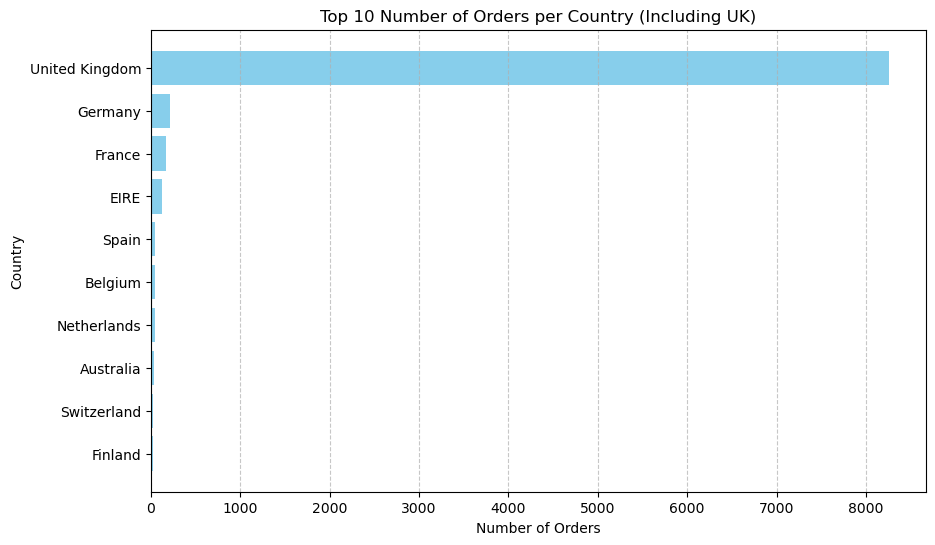

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 Step 1: Load a Subset of Data for Faster Processing
df_sample = df[['Country', 'InvoiceNo']].drop_duplicates().sample(frac=0.5, random_state=42)

# 🔹 Step 2: Aggregate Data Efficiently
country_orders = df_sample.groupby("Country")["InvoiceNo"].count().nlargest(10).reset_index()

# 🔹 Step 3: Matplotlib Bar Chart (Faster than Plotly)
plt.figure(figsize=(10, 6))
plt.barh(country_orders["Country"], country_orders["InvoiceNo"], color='skyblue')
plt.xlabel("Number of Orders")
plt.ylabel("Country")
plt.title("Top 10 Number of Orders per Country (Including UK)")
plt.gca().invert_yaxis()  # Show highest values at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


UK has more number of orders witk 16k Invoice numbers 

C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\3906993193.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df.groupby("Country")["InvoiceNo"]


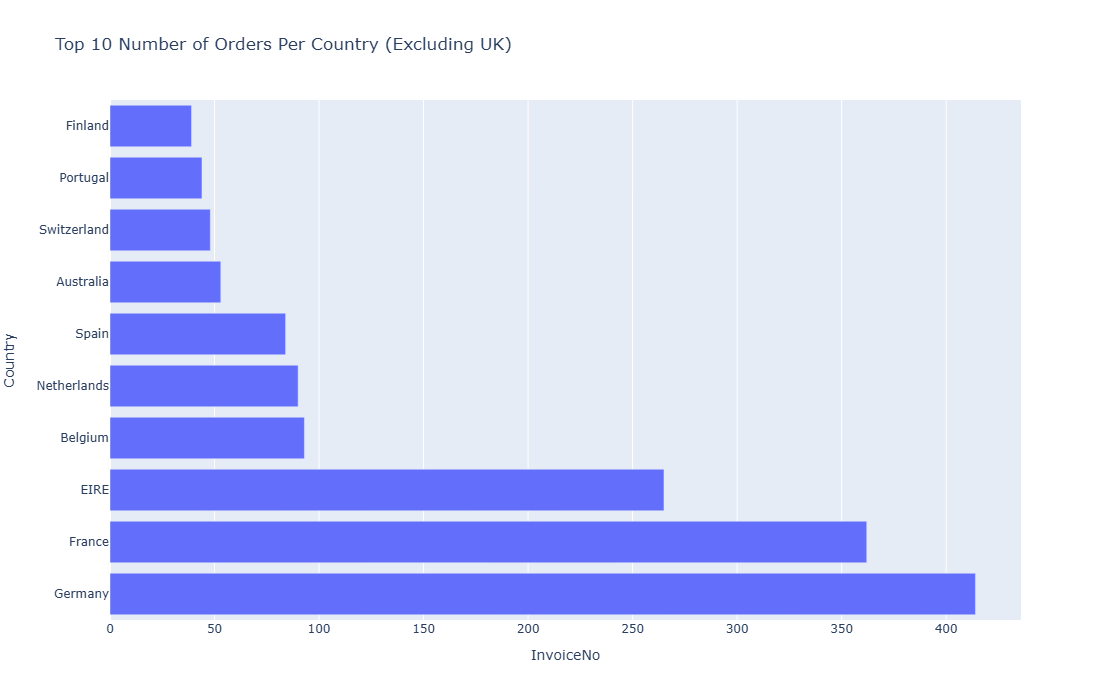

In [16]:
import pandas as pd
import plotly.express as px

# Reduce the dataset size before grouping
filtered_df = df[df['Country'] != "United Kingdom"].copy()

# Convert InvoiceNo to category type for faster computation
filtered_df["InvoiceNo"] = filtered_df["InvoiceNo"].astype("category")

# Perform the grouping and aggregation
Country_Data = (
    filtered_df.groupby("Country")["InvoiceNo"]
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .head(10)
)

# Plot using Plotly
fig = px.bar(
    Country_Data,
    x="InvoiceNo",
    y="Country",
    title="Top 10 Number of Orders Per Country (Excluding UK)",
    height=700,
    width=1000
)

fig.show()


The above charts show that the UK by far has more invoices, just as suspected, with invoices surpassing 15K. Germany in in second place, with approximately 30 time less invoices. The retail store management can start possing question of why this is the case, especially when this is a Online retail store. Question like, what is the traffic like to the store web page, or should they start thinking of ***Search Engine Optimization (SEO)***, which is the process of improving the quality and quantity of website traffic to a website or a web page from search engines. Many other questions can be raised from the 2 charts above.

We can take a look at how the countries fare up with regards to the ***Quantity sold*** and ***Sales Revenue***.The first plot is going to be for Quantity sold and the second will be for Sales Revenue both for the whole year of 2011.

C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\1993746262.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



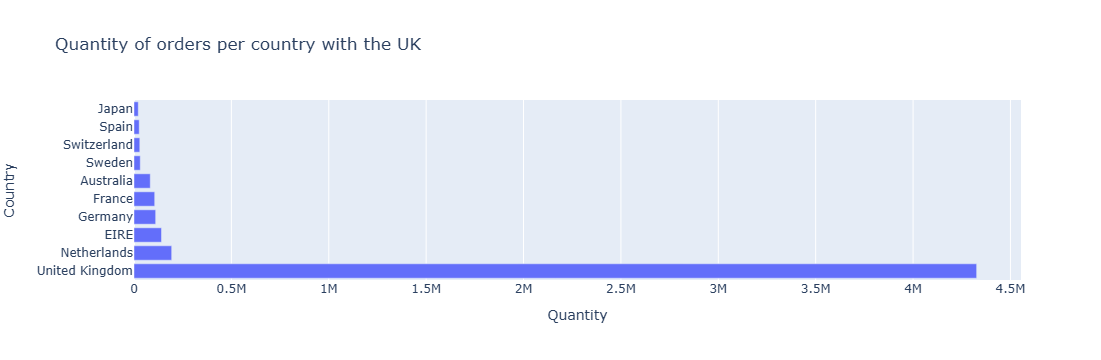

In [17]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Country').dropna()
temp_df = temp_df.sort_values(by="Quantity", ascending=False).head(10)  # Top 10 countries by Quantity

# Generate bar chart
fig = px.bar(temp_df, x="Quantity", y="Country", title="Quantity of orders per country with the UK")
fig.show()

C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\1993746262.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



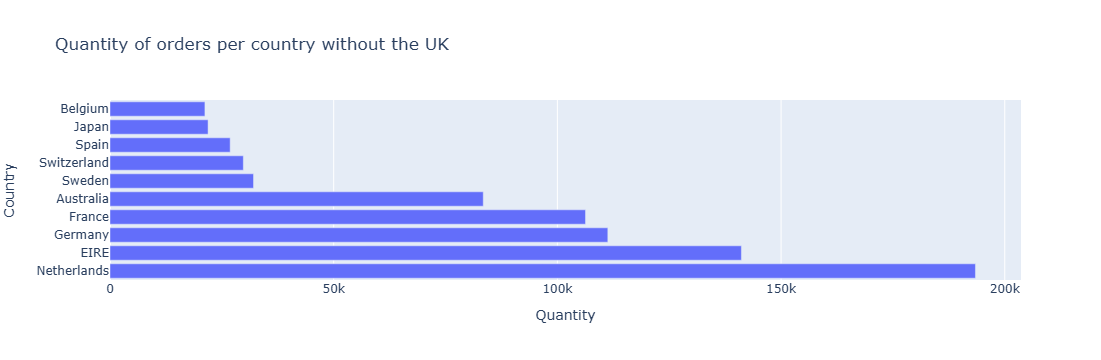

In [18]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Country').dropna()
temp_df = temp_df[temp_df['Country'] != "United Kingdom"].sort_values(by="Quantity", ascending=False).head(10)

# Generate bar chart
fig = px.bar(temp_df, x="Quantity", y="Country", title="Quantity of orders per country without the UK")
fig.show()

Just as expected, the UK has high volumes of Quantitly sold and the below charts should show that the UK has high sales as well. However, unlike the number of invoices, the Netherlands has the second highest volume of Quantity sold at approximately 200K. 

C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\1993746262.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



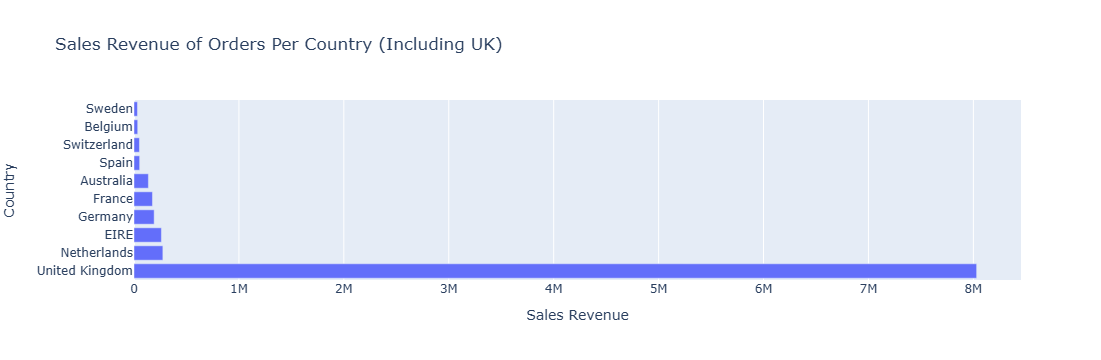

In [19]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Country').dropna()
temp_df = temp_df.sort_values(by="Sales Revenue", ascending=False).head(10)  # Top 10

# Generate bar chart for Sales Revenue per Country (Including UK)
fig = px.bar(temp_df, x="Sales Revenue", y="Country", title="Sales Revenue of Orders Per Country (Including UK)")

# Show Plot
fig.show()


C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\1993746262.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



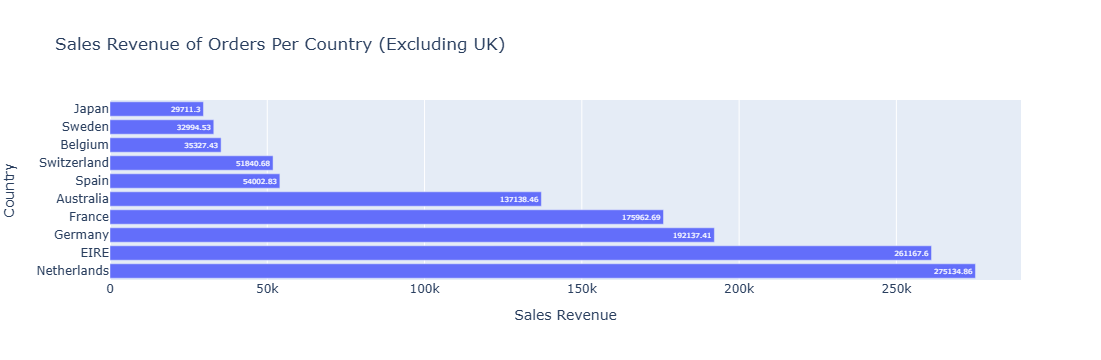

In [20]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Country').dropna()
temp_df = temp_df[temp_df['Country'] != "United Kingdom"]  # Exclude UK
temp_df = temp_df.sort_values(by="Sales Revenue", ascending=False).head(10)  # Top 10 Countries

# Generate Bar Chart
fig = px.bar(temp_df, 
             x="Sales Revenue", 
             y="Country", 
             title="Sales Revenue of Orders Per Country (Excluding UK)", 
             text="Sales Revenue")

# Display the plot
fig.show()

The sales revenue of Netherlands and Germany is quite close. In the streamlit app of this project, a time filter of this project is used to breakedown by time periods 'Month', 'Week', 'Day of the Week', 'Time of Day' ,or 'Hour'.

We now going to look at the products, which ones have high Quantity sold, or which product has high Sales Revenue. But first the below chart is a wordcloud of the product descriptions. A wordcloud is a visual representations of words that give greater prominence to words that appear more frequently, in this case the frequency is the 'Quantity'

In [21]:
def wordcloud_of_Description(df, title):
    """
    This fuction creates a word cloud
    inputs a data frame converts it to tuples and uses the input 'title' as the title of the word cloud
    """
    plt.rcParams["figure.figsize"] = (20,20)
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()


def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

We can create a word cloud of the Product Descriptions per Quantity

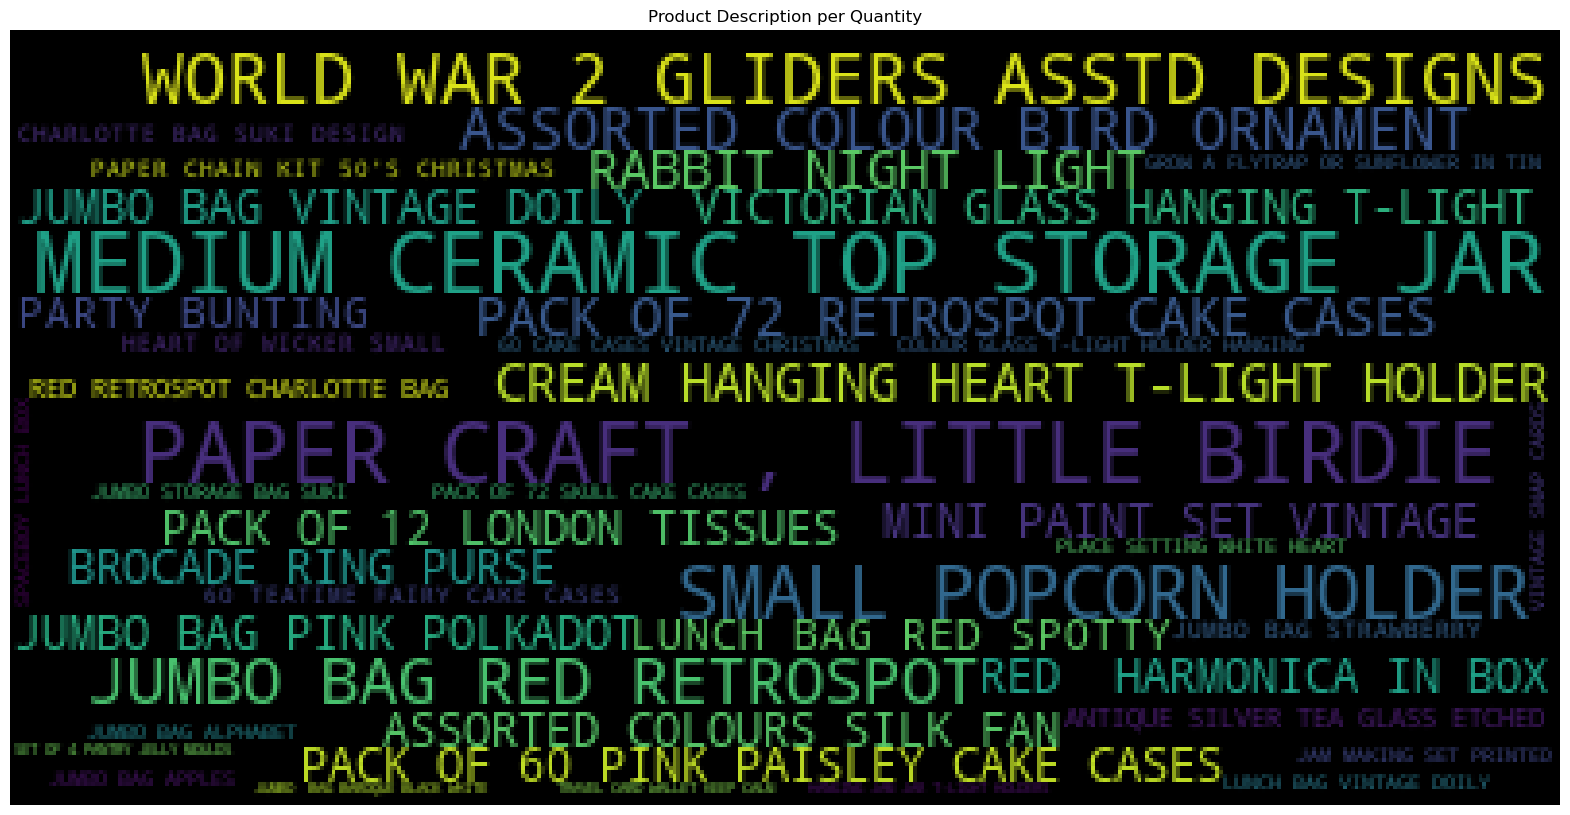

In [22]:
temp_df = pd.DataFrame(df.groupby('Description')['Quantity'].sum()).reset_index()
title = "Product Description per Quantity"
wordcloud_of_Description(temp_df, title)

We can create a word cloud of the Product Descriptions per Sales Revenue

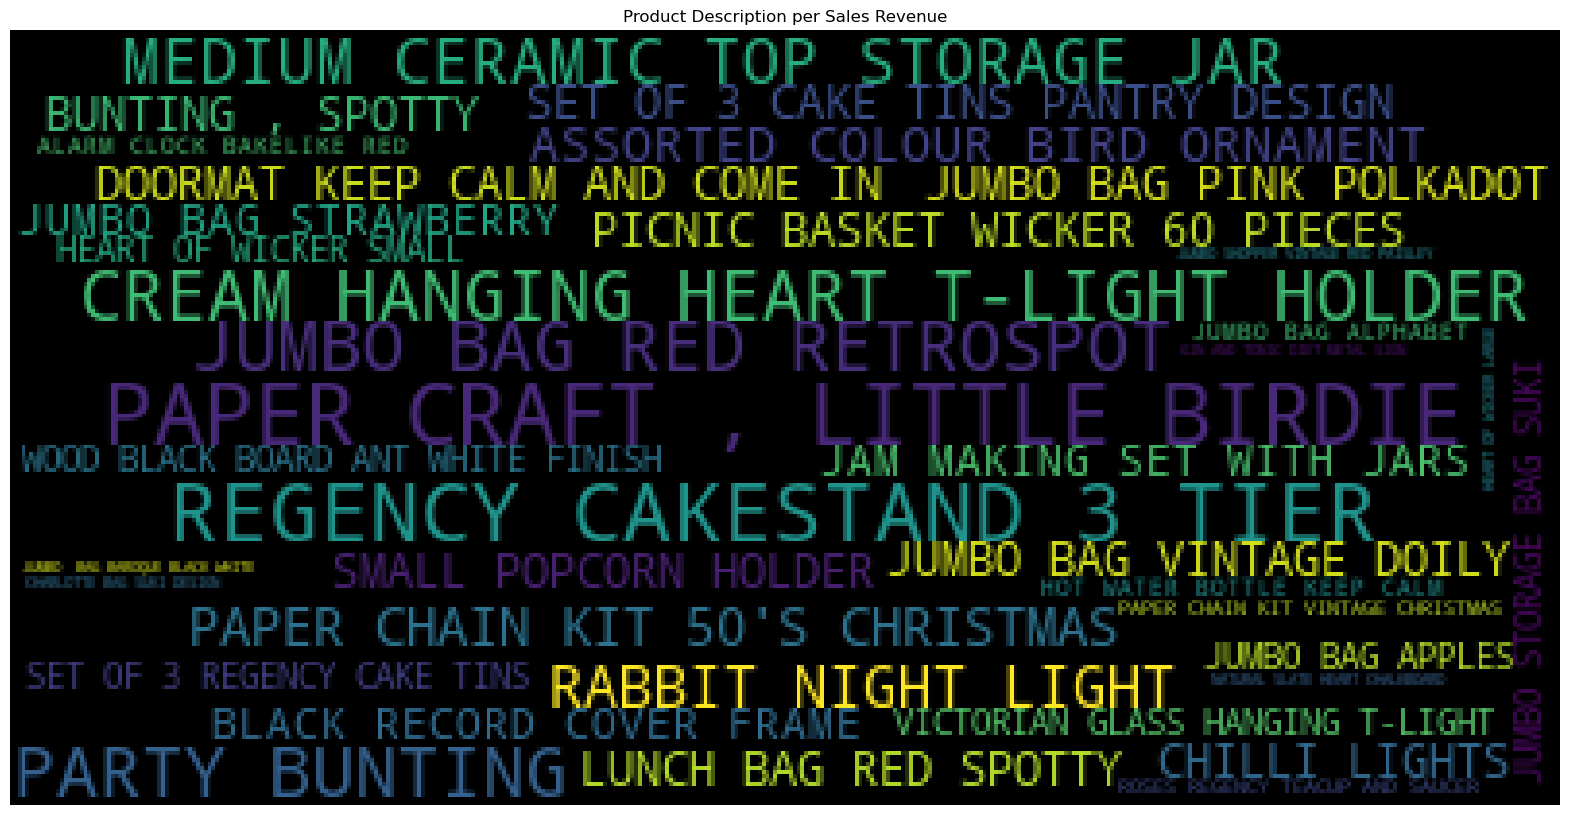

In [23]:
temp_df = pd.DataFrame(df.groupby('Description')['Sales Revenue'].sum()).reset_index()
title = "Product Description per Sales Revenue"
wordcloud_of_Description(temp_df, title)

#### ***Monthly Stats*** 

Below are the monthly analysis of the Sales and the Quantity of iterms sold

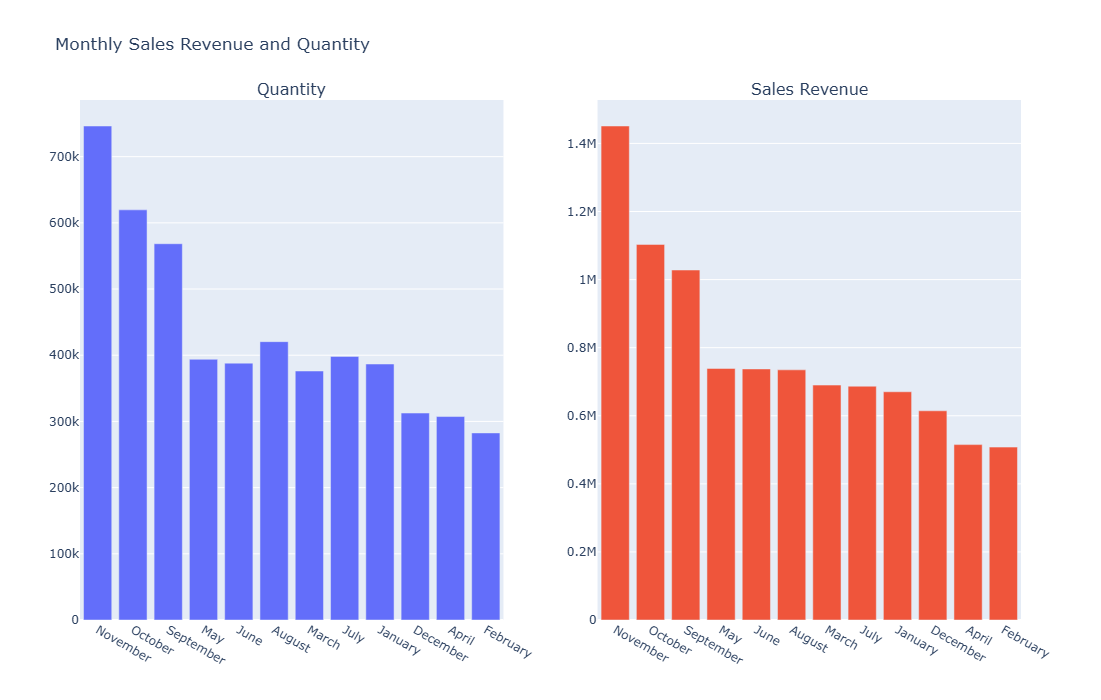

In [24]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Month').dropna()

# **Ensure Correct Column Names**
correct_column_name = "Sales Revenue" if "Sales Revenue" in temp_df.columns else "SalesRevenue"

# **Plot Using Subplots**
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                    subplot_titles=("Quantity", "Sales Revenue"))

# **Add Quantity Plot**
fig.add_trace(go.Bar(x=temp_df['Month'].astype(str), 
                      y=temp_df['Quantity'], 
                      name='Quantity'), row=1, col=1)

# **Add Sales Revenue Plot**
fig.add_trace(go.Bar(x=temp_df['Month'].astype(str), 
                      y=temp_df[correct_column_name], 
                      name='Sales Revenue'), row=1, col=2)

# **Update Layout**
fig.update_layout(showlegend=False, 
                  title_text="Monthly Sales Revenue and Quantity", 
                  height=700, width=1200)

# **Display the Plot**
fig.show()


The above graphs show the monthly trend of Quantity of products ordered(left) and Sales Revenue(right). Both the measures were the highest in Novemeber folllowed by October and Septemeber.

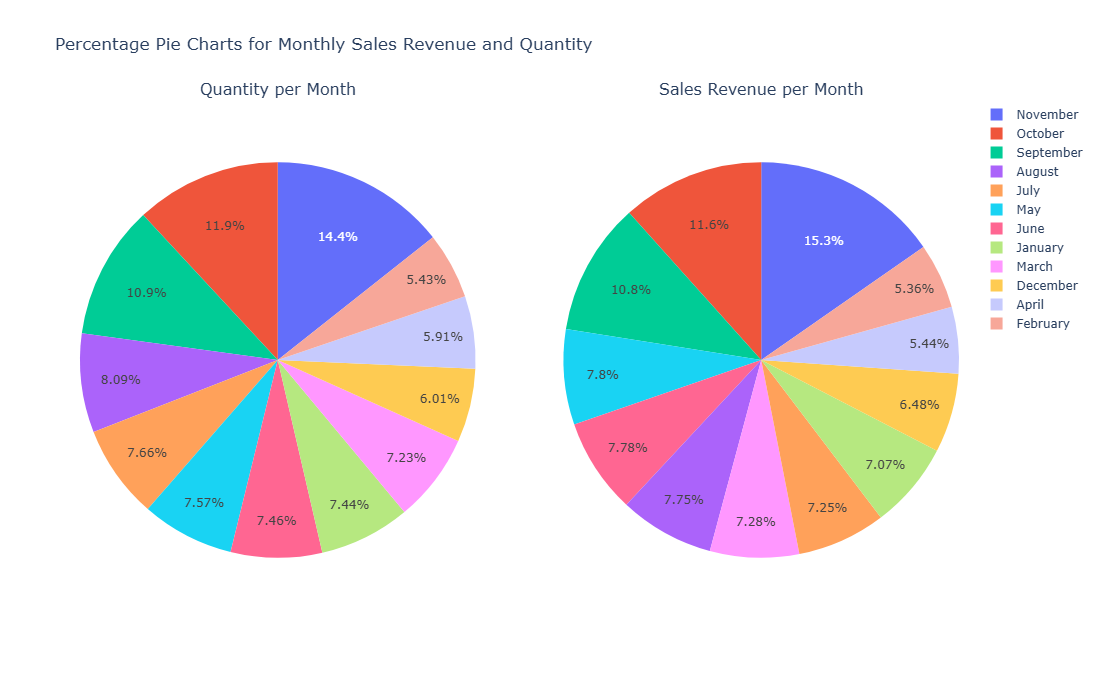

In [25]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity per Month", "Sales Revenue per Month"))

# **Add Quantity Pie Chart**
fig.add_trace(
    go.Pie(values=temp_df['Quantity'], 
           labels=temp_df['Month'], 
           name='Quantity'),
    row=1, col=1
)

# **Add Sales Revenue Pie Chart**
fig.add_trace(
    go.Pie(values=temp_df[correct_column_name], 
           labels=temp_df['Month'], 
           name='Sales Revenue'),
    row=1, col=2
)

# **Update Layout**
fig.update_layout(title_text="Percentage Pie Charts for Monthly Sales Revenue and Quantity",
                  height=700, width=1200)

# **Display the Plot**
fig.show()


The above pie charts depicts the quantity of products ordered and sales revenue per month with highest in the month of November with 14.4% and lowest in the month of february with 5.43%.

#### ***Weekly Stats*** 

The below are the weekly analysis of the Sales and the Quantity of iterms sold

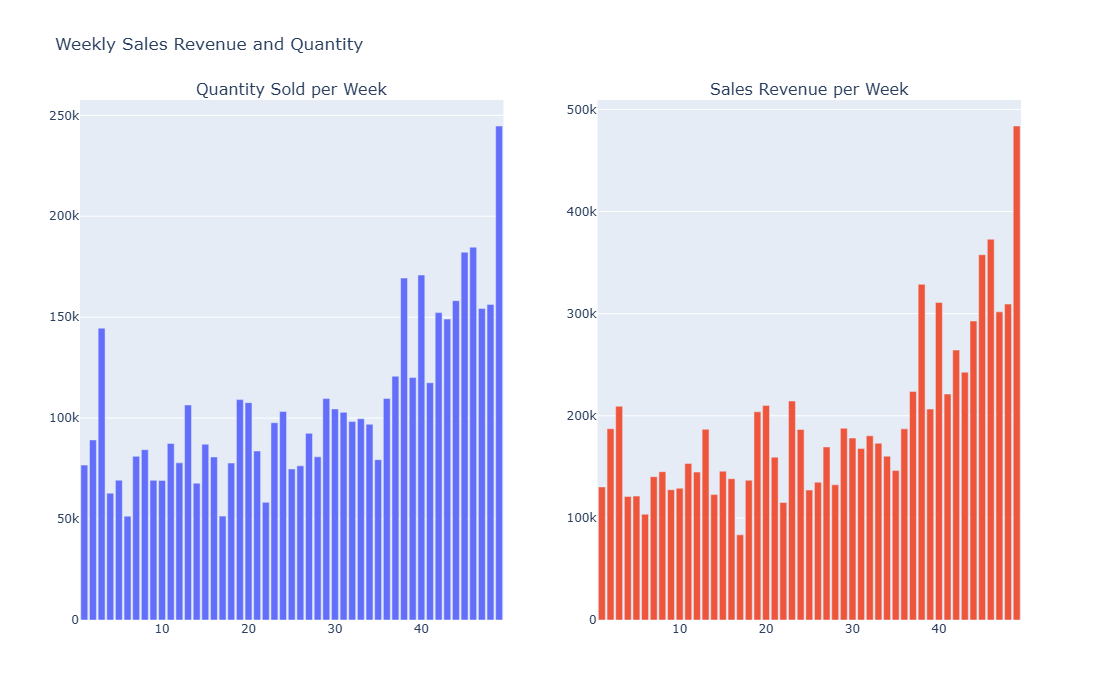

In [26]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Week of the Year')

# Create subplots
fig = make_subplots(
    rows=1, cols=2, shared_yaxes=False,
    subplot_titles=("Quantity Sold per Week", "Sales Revenue per Week")
)

# Add bar charts for quantity and sales revenue
fig.add_trace(
    go.Bar(x=temp_df['Week of the Year'], y=temp_df['Quantity'], name='Quantity'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=temp_df['Week of the Year'], y=temp_df['Sales Revenue'], name='Sales Revenue'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text="Weekly Sales Revenue and Quantity",
    height=700, width=1200,
    showlegend=False
)

# Display the figure
fig.show()


The above graphs shows the weekly trend of sales revenue and the quantity of products ordered. The highest peak was on the 49th week in the month of November. As it's a holiday season, there was a high demand for the decoration items. As the quantity increases sales revenue too increases.

#### ***Daily Stats*** 

The below are the daily analysis of the Sales and the Quantity of iterms sold

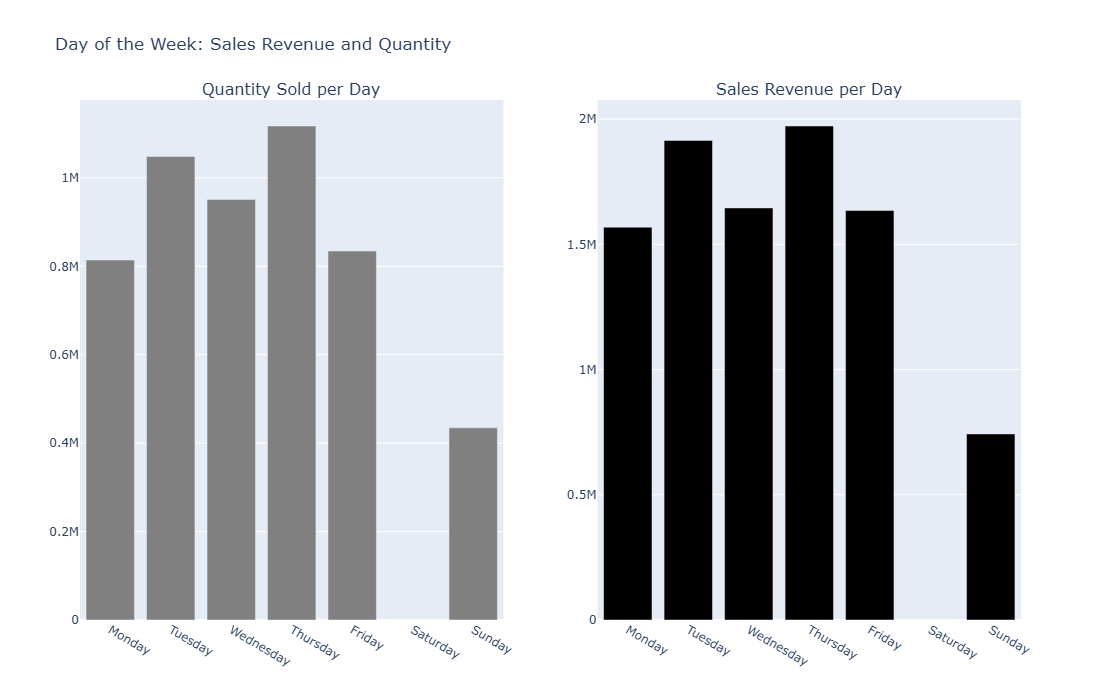

In [27]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Day of Week')

# Define the order of the days for better visualization
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
temp_df = temp_df.set_index("Day of Week").reindex(day_order).reset_index()

# Create subplots
fig = make_subplots(
    rows=1, cols=2, shared_yaxes=False,
    subplot_titles=("Quantity Sold per Day", "Sales Revenue per Day")
)

# Add bar charts for quantity and sales revenue
fig.add_trace(
    go.Bar(x=temp_df['Day of Week'], y=temp_df['Quantity'], name='Quantity', marker_color='grey'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=temp_df['Day of Week'], y=temp_df['Sales Revenue'], name='Sales Revenue', marker_color='black'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text="Day of the Week: Sales Revenue and Quantity",
    height=700, width=1200,
    showlegend=False
)

# Display the figure
fig.show()

The above graphs depict the daily trend of Sales revenue and quantity. Thursday was observed to generate the highest quantity of products and Sales Revenue.

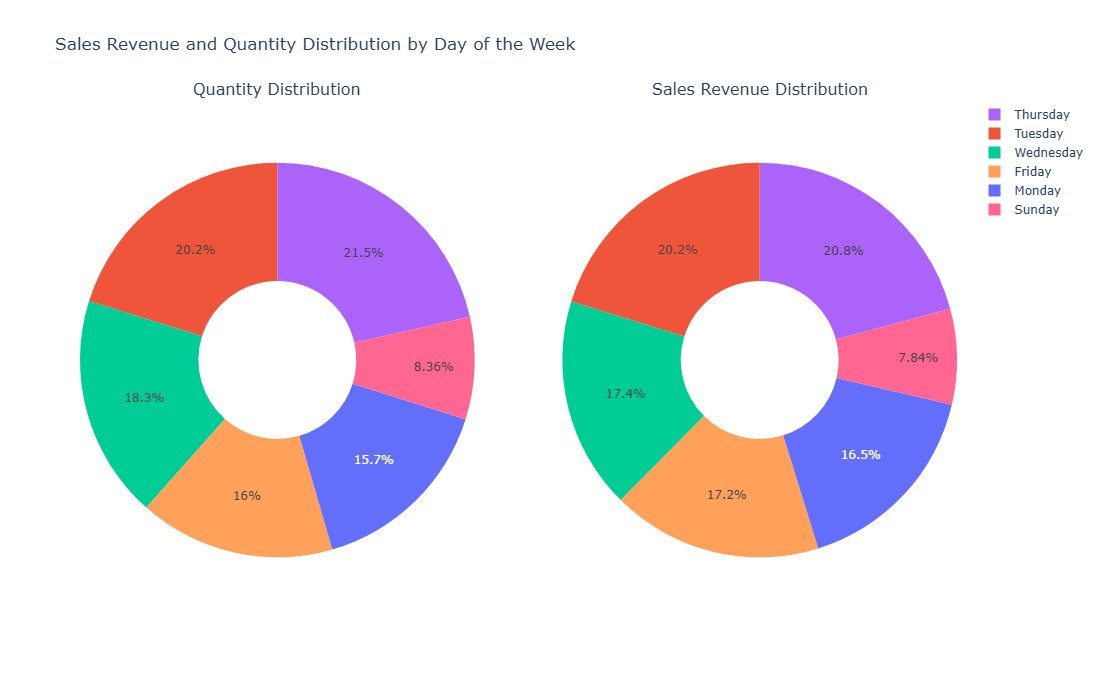

In [28]:
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=("Quantity Distribution", "Sales Revenue Distribution")
)

# Add Quantity Pie Chart
fig.add_trace(
    go.Pie(
        values=temp_df['Quantity'],
        labels=temp_df['Day of Week'],
        name='Quantity',
        hole=0.4,  # Creates a donut chart for better readability
        marker=dict(colors=['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692'])
    ),
    row=1, col=1
)

# Add Sales Revenue Pie Chart
fig.add_trace(
    go.Pie(
        values=temp_df['Sales Revenue'],
        labels=temp_df['Day of Week'],
        name='Sales Revenue',
        hole=0.4,
        marker=dict(colors=['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692'])
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text="Sales Revenue and Quantity Distribution by Day of the Week",
    height=700, width=1200,
    showlegend=True
)

# Display the plot
fig.show()


In [29]:
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Date', 'Month',
       'Week of the Year', 'Day of Week', 'Time', 'Hour', 'Time of Day',
       'Sales Revenue'],
      dtype='object')


The above pie charts shows the daily trend of sales revenue and quantity of products ordered. 

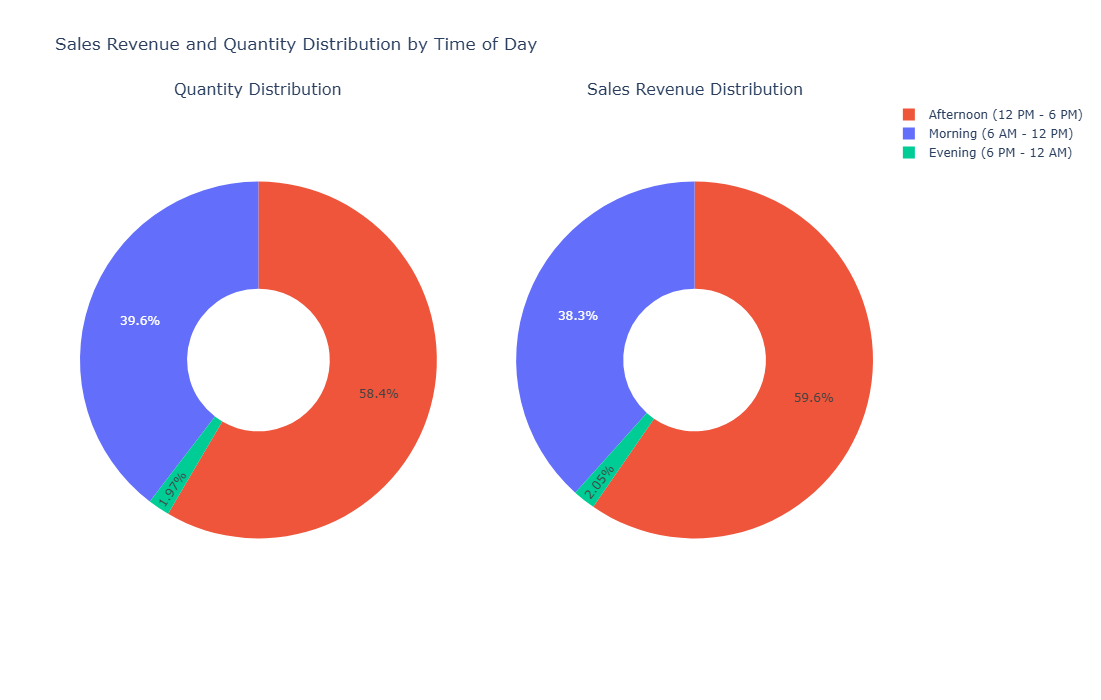

In [30]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Extract "Hour" from "InvoiceDate"
df["Hour"] = df["InvoiceDate"].dt.hour

# Function to classify time of day
def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return "Morning (6 AM - 12 PM)"
    elif 12 <= hour < 18:
        return "Afternoon (12 PM - 6 PM)"
    elif 18 <= hour < 24:
        return "Evening (6 PM - 12 AM)"
    else:
        return "Night (12 AM - 6 AM)"

# Apply classification
df["Time of Day"] = df["Hour"].apply(assign_time_of_day)

# Aggregate data by "Time of Day"
time_order = ["Morning (6 AM - 12 PM)", "Afternoon (12 PM - 6 PM)", 
              "Evening (6 PM - 12 AM)", "Night (12 AM - 6 AM)"]

df_grouped = df.groupby("Time of Day")[["Quantity", "Sales Revenue"]].sum().reindex(time_order).dropna().reset_index()

# Create pie charts
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "pie"}, {"type": "pie"}]],
    subplot_titles=("Quantity Distribution", "Sales Revenue Distribution")
)

# Add Quantity Pie Chart
fig.add_trace(
    go.Pie(
        values=df_grouped['Quantity'],
        labels=df_grouped['Time of Day'],
        name='Quantity',
        hole=0.4,  
        marker=dict(colors=['#636EFA', '#EF553B', '#00CC96', '#FFA15A'])
    ),
    row=1, col=1
)

# Add Sales Revenue Pie Chart
fig.add_trace(
    go.Pie(
        values=df_grouped['Sales Revenue'],
        labels=df_grouped['Time of Day'],
        name='Sales Revenue',
        hole=0.4,
        marker=dict(colors=['#636EFA', '#EF553B', '#00CC96', '#FFA15A'])
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text="Sales Revenue and Quantity Distribution by Time of Day",
    height=700, width=1200,
    showlegend=True
)

# Display the plot
fig.show()

The above piecharts shows the breakdown of Quantity of orders(left) and Sales revenue(right) by time of the day.  More than 99% of the orders were placed during mornings and afternoon.

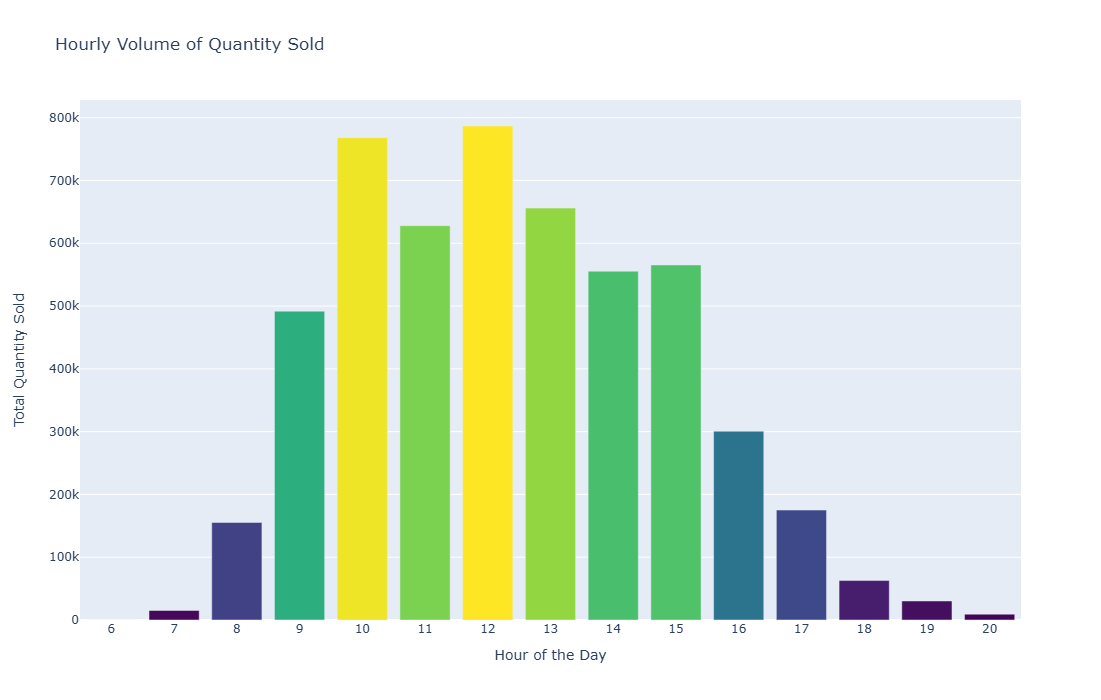

In [31]:
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce')

Hourly_Sales = df.groupby('Hour', as_index=False)['Quantity'].sum()

# Sort by hour for proper visualization
Hourly_Sales = Hourly_Sales.sort_values(by='Hour')

# Create the bar chart
fig = px.bar(
    Hourly_Sales, 
    x='Hour', 
    y='Quantity', 
    title='Hourly Volume of Quantity Sold',
    labels={'Quantity': 'Total Quantity Sold', 'Hour': 'Hour of the Day'},
    color='Quantity',
    color_continuous_scale='viridis'
)

# Customize layout
fig.update_layout(
    height=700, width=1000,
    xaxis=dict(tickmode='linear', tick0=0, dtick=1, title='Hour of the Day'),
    yaxis=dict(title='Total Quantity Sold'),
    coloraxis_showscale=False
)

# Display the plot
fig.show()

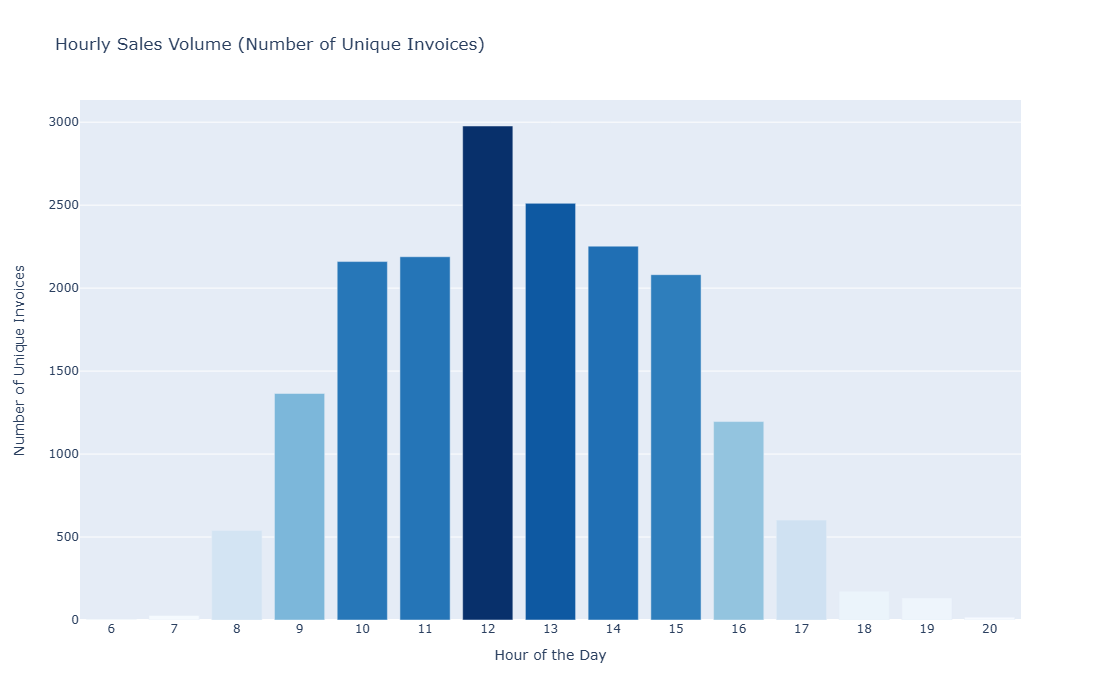

In [32]:
Hourly_Sales = df.groupby('Hour', as_index=False)['InvoiceNo'].nunique()

# Sort by hour for proper visualization
Hourly_Sales = Hourly_Sales.sort_values(by='Hour')

# Create the bar chart
fig = px.bar(
    Hourly_Sales, 
    x='Hour', 
    y='InvoiceNo', 
    title='Hourly Sales Volume (Number of Unique Invoices)',
    labels={'InvoiceNo': 'Number of Invoices', 'Hour': 'Hour of the Day'},
    color='InvoiceNo',
    color_continuous_scale='blues'
)

# Customize layout
fig.update_layout(
    height=700, width=1000,
    xaxis=dict(tickmode='linear', tick0=0, dtick=1, title='Hour of the Day'),
    yaxis=dict(title='Number of Unique Invoices'),
    coloraxis_showscale=False
)

# Display the plot
fig.show()

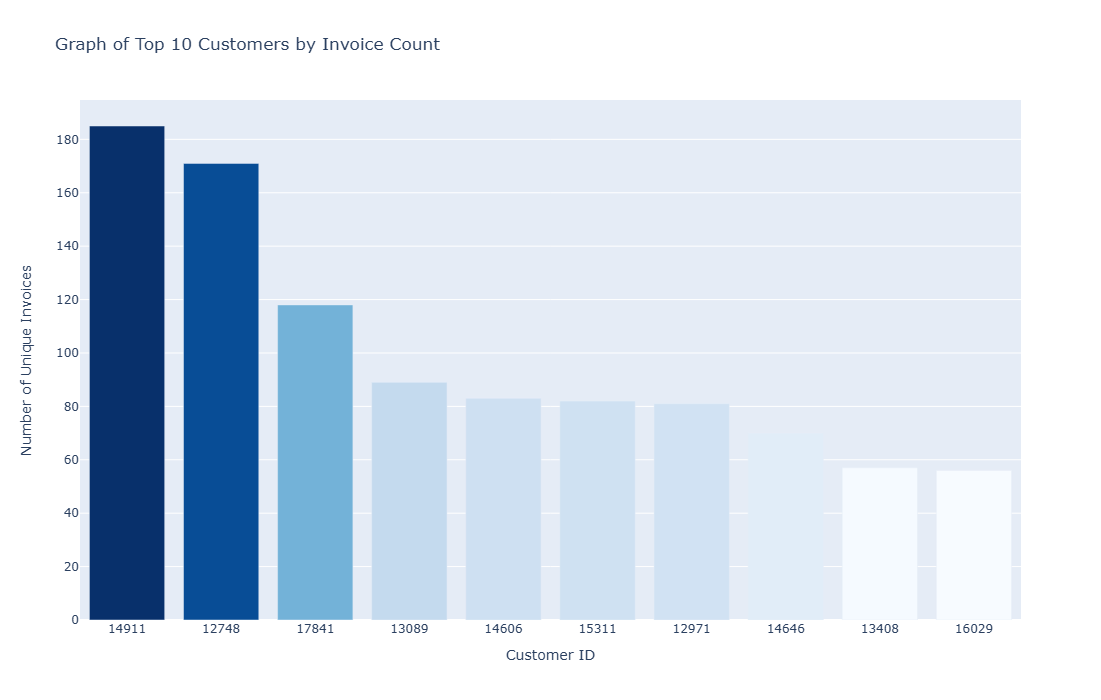

In [33]:
data = df.groupby("CustomerID", as_index=False)["InvoiceNo"].nunique()

# Sort in descending order and select the top 10 customers
data = data.sort_values(by="InvoiceNo", ascending=False).head(10)

# Create the bar chart
fig = px.bar(
    data, 
    x="CustomerID", 
    y="InvoiceNo", 
    title="Graph of Top 10 Customers by Invoice Count",
    labels={"InvoiceNo": "Number of Unique Invoices", "CustomerID": "Customer ID"},
    color="InvoiceNo",
    color_continuous_scale="blues"
)

# Customize layout
fig.update_layout(
    height=700, width=1000,
    xaxis=dict(type='category', title="Customer ID"),
    yaxis=dict(title="Number of Unique Invoices"),
    coloraxis_showscale=False
)

# Display the plot
fig.show()

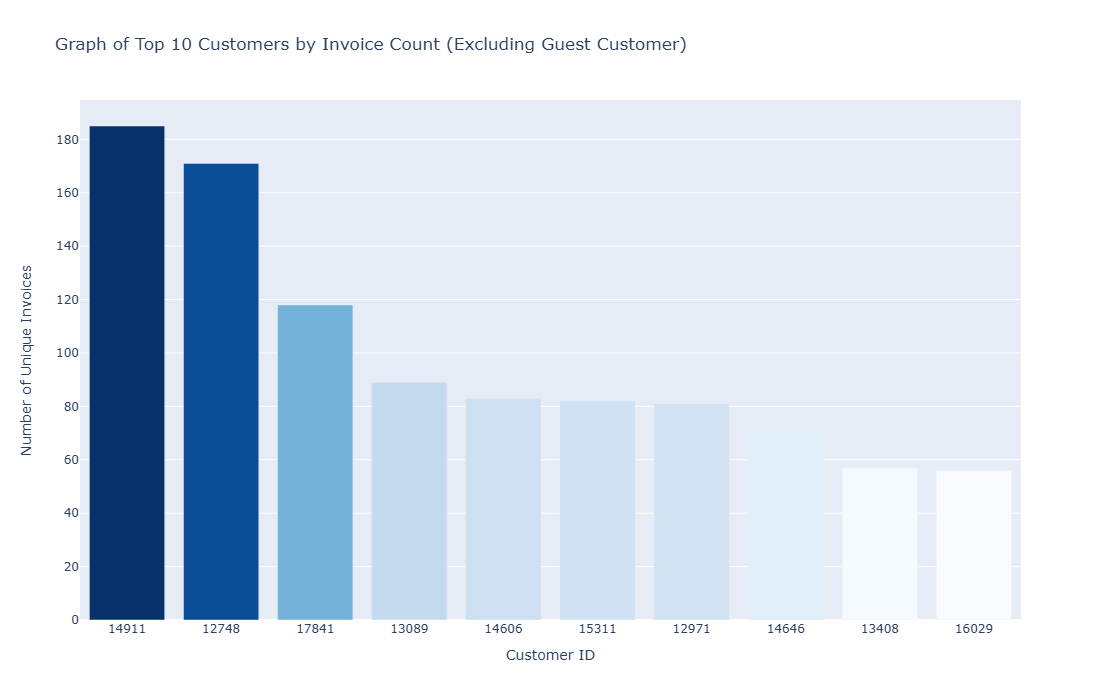

In [34]:
temp_df = df.dropna(subset=["CustomerID"])

# Aggregate number of unique invoices per customer
data = temp_df.groupby("CustomerID", as_index=False)["InvoiceNo"].nunique()

# Sort in descending order and select the top 10 customers
data = data.sort_values(by="InvoiceNo", ascending=False).head(10)

# Create the bar chart
fig = px.bar(
    data, 
    x="CustomerID", 
    y="InvoiceNo", 
    title="Graph of Top 10 Customers by Invoice Count (Excluding Guest Customer)",
    labels={"InvoiceNo": "Number of Unique Invoices", "CustomerID": "Customer ID"},
    color="InvoiceNo",
    color_continuous_scale="blues"
)

# Customize layout
fig.update_layout(
    height=700, width=1000,
    xaxis=dict(type='category', title="Customer ID"),
    yaxis=dict(title="Number of Unique Invoices"),
    coloraxis_showscale=False
)

# Display the plot
fig.show()

In [35]:
temp_df = df.groupby("Description").agg({"Quantity": "sum", "Sales Revenue": "sum"}).reset_index()

# Get the top 10 descriptions by quantity
Quantity_tempA = temp_df.sort_values(by="Quantity", ascending=False).head(10).reset_index(drop=True)

# Get the bottom 10 descriptions by quantity
Quantity_tempB = temp_df.sort_values(by="Quantity", ascending=True).head(10).reset_index(drop=True)

# Drop 'Sales Revenue' column for display
Quantity_tempA.drop(columns=['Sales Revenue'], inplace=True)
Quantity_tempB.drop(columns=['Sales Revenue'], inplace=True)

# Display the dataframes in a readable format
print("🔹 **Top 10 Description by Quantity:**")
display(Quantity_tempA)  # Standard pandas display

print("\n🔹 **Bottom 10 Description by Quantity:**")
display(Quantity_tempB)

🔹 **Top 10 Description by Quantity:**


Description  Quantity
0         PAPER CRAFT , LITTLE BIRDIE     80995
1      MEDIUM CERAMIC TOP STORAGE JAR     78033
2                SMALL POPCORN HOLDER     54158
3   WORLD WAR 2 GLIDERS ASSTD DESIGNS     49660
4             JUMBO BAG RED RETROSPOT     46220
5       ASSORTED COLOUR BIRD ORNAMENT     33977
6  CREAM HANGING HEART T-LIGHT HOLDER     33889
7     PACK OF 72 RETROSPOT CAKE CASES     32253
8                  RABBIT NIGHT LIGHT     30726
9              MINI PAINT SET VINTAGE     23923


🔹 **Bottom 10 Description by Quantity:**


Description  Quantity
0               FLOWER SHOP DESIGN MUG         1
1                     DOLPHIN WINDMILL         1
2  DOTCOMGIFTSHOP GIFT VOUCHER £100.00         1
3        DR. JAM'S AROUZER STRESS BALL         1
4   EASTER CRAFT IVY WREATH WITH CHICK         1
5       EIGHT PIECE CREEPY CRAWLIE SET         1
6          FAIRY CAKE NOTEBOOK A5 SIZE         1
7              FILIGREE DIAMANTE CHAIN         1
8    RED WHITE SCARF  HOT WATER BOTTLE         1
9     DIAMANTE BOW BROOCH BLACK COLOUR         1

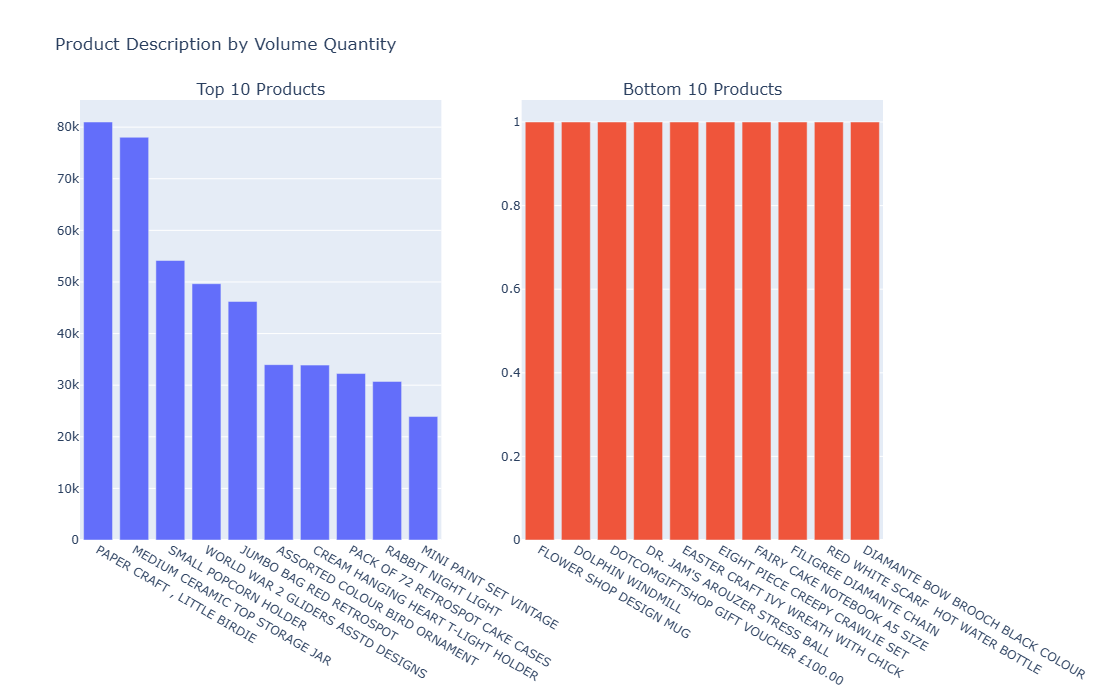

In [36]:
fig = make_subplots(
    rows=1, cols=2, shared_yaxes=False,
    subplot_titles=("Top 10 Products", "Bottom 10 Products")
)

# Add bar charts for top 10 and bottom 10 products
fig.add_trace(
    go.Bar(x=Quantity_tempA['Description'], y=Quantity_tempA['Quantity'], name='Top 10'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=Quantity_tempB['Description'], y=Quantity_tempB['Quantity'], name='Bottom 10'),
    row=1, col=2
)

# Update layout settings for better readability
fig.update_layout(
    title_text="Product Description by Volume Quantity",
    height=700, width=1200,
    showlegend=False
)

# Display the figure
fig.show()

The above graphs depict the top 10 and bottom 10 products by volume quantity. The product paper craft, little birdie was the most popular item whereas orange/fuschia stones necklace was the least popular item.

In [37]:
# Sorting the data by Sales Revenue
Sales_Revenue_tempA = temp_df.sort_values(by="Sales Revenue", ascending=False).head(10).reset_index(drop=True)
Sales_Revenue_tempB = temp_df.sort_values(by="Sales Revenue", ascending=False).tail(10).reset_index(drop=True)

# Dropping 'Quantity' column
Sales_Revenue_tempA = Sales_Revenue_tempA.drop(columns=['Quantity'])
Sales_Revenue_tempB = Sales_Revenue_tempB.drop(columns=['Quantity'])

# Display tables side by side
import pandas as pd
import IPython.display as display

def display_side_by_side(dfs, titles):
    """
    Display multiple DataFrames side by side for better comparison.
    """
    html_str = ''
    for df, title in zip(dfs, titles):
        html_str += df.style.set_table_attributes("style='display:inline'").set_caption(title)._repr_html_()
    display.display_html(html_str, raw=True)

# Display the top 10 and bottom 10 Sales Revenue descriptions
display_side_by_side(
    [Sales_Revenue_tempA, Sales_Revenue_tempB],
    ['Top 10 Description by Sales Revenue\n', 'Bottom 10 Description by Sales Revenue\n']
)


Top 10 Description by Sales Revenue
 
 
 
   
 Description 
 Sales Revenue 
 
 
 
 
 0 
 PAPER CRAFT , LITTLE BIRDIE 
 168469.600000 
 
 
 1 
 REGENCY CAKESTAND 3 TIER 
 146436.280000 
 
 
 2 
 PARTY BUNTING 
 98237.490000 
 
 
 3 
 CREAM HANGING HEART T-LIGHT HOLDER 
 94027.390000 
 
 
 4 
 JUMBO BAG RED RETROSPOT 
 90140.660000 
 
 
 5 
 MEDIUM CERAMIC TOP STORAGE JAR 
 81700.920000 
 
 
 6 
 RABBIT NIGHT LIGHT 
 66842.990000 
 
 
 7 
 PAPER CHAIN KIT 50'S CHRISTMAS 
 55667.490000 
 
 
 8 
 ASSORTED COLOUR BIRD ORNAMENT 
 54918.090000 
 
 
 9 
 PICNIC BASKET WICKER 60 PIECES 
 50287.910000 
 
 
 

 
 Bottom 10 Description by Sales Revenue
 
 
 
   
 Description 
 Sales Revenue 
 
 
 
 
 0 
 WIRE FLOWER T-LIGHT HOLDER 
 1.250000 
 
 
 1 
 PACK 4 FLOWER/BUTTERFLY PATCHES 
 1.250000 
 
 
 2 
 GREEN POP ART MAO CUSHION COVER 
 1.140000 
 
 
 3 
 60 GOLD AND SILVER FAIRY CAKE CASES 
 1.100000 
 
 
 4 
 HAPPY BIRTHDAY CARD TEDDY/CAKE 
 0.950000 
 
 
 5 
 CAT WITH SUNGLASSES BLANK CARD 
 0.950000 
 
 
 6 
 PINK CRYSTAL GUITAR PHONE CHARM 
 0.850000 
 
 
 7 
 FAIRY CAKE NOTEBOOK A5 SIZE 
 0.850000 
 
 
 8 
 HEN HOUSE W CHICK IN NEST 
 0.420000 
 
 
 9 
 PADS TO MATCH ALL CUSHIONS 
 0.003000

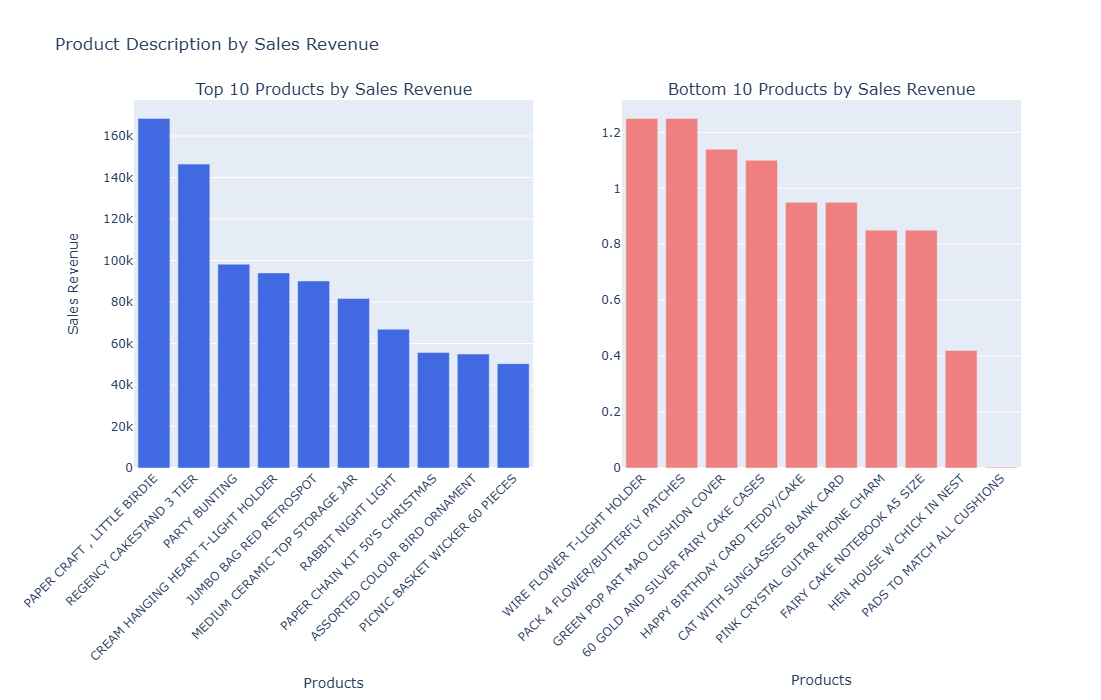

In [38]:
fig = make_subplots(
    rows=1, cols=2, shared_yaxes=False,
    subplot_titles=("Top 10 Products by Sales Revenue", "Bottom 10 Products by Sales Revenue")
)

# Add top 10 products by Sales Revenue
fig.add_trace(
    go.Bar(
        x=Sales_Revenue_tempA['Description'],
        y=Sales_Revenue_tempA['Sales Revenue'],
        name='Top 10',
        marker=dict(color='royalblue')
    ),
    row=1, col=1
)

# Add bottom 10 products by Sales Revenue
fig.add_trace(
    go.Bar(
        x=Sales_Revenue_tempB['Description'],
        y=Sales_Revenue_tempB['Sales Revenue'],
        name='Bottom 10',
        marker=dict(color='lightcoral')
    ),
    row=1, col=2
)

# Update layout for better readability
fig.update_layout(
    title_text="Product Description by Sales Revenue",
    showlegend=False,
    height=700,
    width=1200,
    xaxis=dict(title="Products", tickangle=-45),
    yaxis=dict(title="Sales Revenue"),
    xaxis2=dict(title="Products", tickangle=-45),
)

# Show the figure
fig.show()

The above graphs depict the top 10 and bottom 10 products by sales revenue. The product paper craft, little birdie was found to be generating the highest sales and pads had the lowest sales.

### **Market Basket Analysis**

**What is Market Basket Analysis?:**

Market Basket Analysis (MBA) is a data mining technique that is mostly used in the Retail Industry to uncover customer purchasing patterns and product relationships. The techniques used in MBA identify the patterns, associations, and relationships (revealing product groupings and which products are likely to be purchased together) in in frequently purchased items by customers in large transaction datasets collected/registered at the point of sale. The results of the Market Basket Analysis can be used by retailers or marketers to design and develop marketing and operation strategies for a retail business or organization.<br>
Market basket analysis mainly utilize Association Rules {IF} -> {THEN}. However, MBA assigns Business outcomes and scenarios to the rules, for example,{IF X is bought} -> {THEN Y is also bought}, so X,Y could be sold together. <br>

Definition: **Association Rule**

Let $I$= \{$i_{1},i_{2},\ldots ,i_{n}$\} be an itemset.

Let $D$= \{$t_{1},t_{2},\ldots ,t_{m}$\} be a database of transactions $t$. Where each transaction $t$ is a nonempty itemset such that ${t \subseteq I}$

Each transaction in D has a unique transaction ID and contains a subset of the items in I.

A rule is defined as an implication of the form:
$X\Rightarrow Y$, where ${X,Y\subseteq I}$.

The rule ${X \Rightarrow Y}$ holds in the dataset of transactions $D$ with support $s$, where $s$ is the percentage of transactions in $D$ that contain ${X \cup Y}$ (that is the union of set $X$ and set $Y$, or, both $X$ and $Y$). This is taken as the probability, ${P(X \cup Y)}$. Rule ${X \Rightarrow Y}$ has confidence $c$ in the transaction set $D$, where $c$ is the percentage of transactions in $D$ containing $X$ that also contains $Y$. This is taken to be the conditional probability, like ${P(Y \vert X)}$. That is,

* support ${(X \Rightarrow Y)}$ = ${P(X \cup Y)}$

* confidence ${(X \Rightarrow Y)}$ = ${P(X \vert Y)}$

The lift of the rule ${(X \Rightarrow Y)}$  is the confidence of the rule divided by the expected confidence, assuming that the itemsets $X$ and $Y$ are independent of each other.The expected confidence is the confidence divided by the frequency of ${Y}$.

* lift ${(X \Rightarrow Y)}$ = ${\frac {\mathrm {supp} (X\cap Y)}{\mathrm {supp} (X)\times \mathrm {supp} (Y)}}$


Lift value near 1 indicates ${X}$ and ${Y}$ almost often appear together as expected, greater than 1 means they appear together more than expected and less than 1 means they appear less than expected.Greater lift values indicate stronger association

##### **Benefit of MBA**

We are going to make a list of countries, this way a user (either in this notebook or the streamlit tool) can toggle through the countries and do MBA for just that country

In [39]:
country_list = list(dict(df['Country'].value_counts()).keys())
def choose_country(country = "all", data = df):
  """
  This fuction takes in a country name and filters the data frame for just country
  if the there is no country inputed the fuction return the un filtered dataframe
  """
  if country == "all":
    return data
  else:
    temp_df = data[data["Country"] == country]
    temp_df.reset_index(drop= True, inplace= True)

    return temp_df


In [40]:
#we are going to use the UK 
MBA_df = choose_country(country="United Kingdom")
MBA_df.head()

InvoiceNo StockCode                Description  Quantity  \
0    539993     22386    JUMBO BAG PINK POLKADOT        10   
1    539993     21499         BLUE POLKADOT WRAP        25   
2    539993     21498         RED RETROSPOT WRAP        25   
3    539993     22379    RECYCLING BAG RETROSPOT         5   
4    539993     20718  RED RETROSPOT SHOPPER BAG        10   

          InvoiceDate  UnitPrice  CustomerID         Country        Date  \
0 2011-01-04 10:00:00       1.95     13313.0  United Kingdom  2011-01-04   
1 2011-01-04 10:00:00       0.42     13313.0  United Kingdom  2011-01-04   
2 2011-01-04 10:00:00       0.42     13313.0  United Kingdom  2011-01-04   
3 2011-01-04 10:00:00       2.10     13313.0  United Kingdom  2011-01-04   
4 2011-01-04 10:00:00       1.25     13313.0  United Kingdom  2011-01-04   

     Month  Week of the Year Day of Week      Time  Hour  \
0  January                 1     Tuesday  10:00:00    10   
1  January                 1     Tuesday  10:00:00    10   
2  January                 1     Tuesday  10:00:00    10   
3  January                 1     Tuesday  10:00:00    10   
4  January                 1     Tuesday  10:00:00    10   

              Time of Day  Sales Revenue  
0  Morning (6 AM - 12 PM)           19.5  
1  Morning (6 AM - 12 PM)           10.5  
2  Morning (6 AM - 12 PM)           10.5  
3  Morning (6 AM - 12 PM)           10.5  
4  Morning (6 AM - 12 PM)           12.5

We are going to use the Apriori Algorithm for the association rule mining/analysis. Apriori is an algorithm for frequent item set mining and association rule learning over relational dataset. It proceeds by identifying the frequent individual items in the dataset and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the dataset. The frequent item sets determined by Apriori can be used to determine association rules which highlight general trends, pattern, and relationships in the dataset

In [41]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [42]:
import pandas as pd

# Ensure 'Description' is a string type
df['Description'] = df['Description'].astype(str)

# Ensure 'Quantity' is numeric and positive
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0).astype(int)
df = df[df['Quantity'] > 0]  # Remove negative quantities (returns)

# Grouping data to create a basket matrix for Market Basket Analysis
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack(fill_value=0)

# Check if basket contains only zeros
if (basket.sum(axis=1) == 0).all():
    print("⚠️ Warning: Basket matrix contains only zeros. Check data processing steps.")

# Convert to binary format for Market Basket Analysis (1 = bought, 0 = not bought)
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)

# Display the processed basket matrix
from IPython.display import display
display(basket_binary.head())

# Summary check
print(f"Total Rows: {basket_binary.shape[0]}")
print(f"Total Columns: {basket_binary.shape[1]}")
print(f"Non-Zero Entries: {basket_binary.sum().sum()} (should not be zero)")


C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\794638302.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\nisha\AppData\Local\Temp\ipykernel_15480\794638302.py:18: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
539993                            0                           0   
540001                            0                           0   
540002                            0                           0   
540003                            0                           0   
540004                            0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
539993                               0                          0   
540001                               0                          0   
540002                               0                          0   
540003                               0                          0   
540004                               0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
539993                                  0                                 0   
540001                                  0                                 0   
540002                                  0                                 0   
540003                                  0                                 0   
540004                                  0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
539993                                     0                              0   
540001                                     0                              0   
540002                                     0                              0   
540003                                     0                              0   
540004                                     0                              0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
539993                                         0                            0   
540001                                         0                            0   
540002                                         0                            0   
540003                                         0                            0   
540004                                         0                            0   

Description  ...  ZINC METAL HEART DECORATION  ZINC STAR T-LIGHT HOLDER  \
InvoiceNo    ...                                                          
539993       ...                            0                         0   
540001       ...                            0                         0   
540002       ...                            0                         0   
540003       ...                            0                         0   
540004       ...                            0                         0   

Description  ZINC SWEETHEART SOAP DISH  ZINC SWEETHEART WIRE LETTER RACK  \
InvoiceNo                                                                  
539993                               0                                 0   
540001                               0                                 0   
540002                               0                                 0   
540003                               0                                 0   
540004                               0                                 0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
539993                                     0                                0   
540001                                     0                        

Total Rows: 18222
Total Columns: 3701
Non-Zero Entries: 476294 (should not be zero)


From the above table we are going to make that very value that is less than or equal to 0 be zero and anything else be equal to 1.
This is called one hot encoding and we will use the buit in pandas `applymap()`function with a custom function as input to check the condition stated above

In [43]:
def encoder(x):
    return 1 if x > 0 else 0  # Simplified version

# Apply encoding correctly to the entire DataFrame
basket = basket.apply(lambda col: col.map(encoder))

# Display the processed basket
basket.head()


Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
539993                            0                           0   
540001                            0                           0   
540002                            0                           0   
540003                            0                           0   
540004                            0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
539993                               0                          0   
540001                               0                          0   
540002                               0                          0   
540003                               0                          0   
540004                               0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
539993                                  0                                 0   
540001                                  0                                 0   
540002                                  0                                 0   
540003                                  0                                 0   
540004                                  0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
539993                                     0                              0   
540001                                     0                              0   
540002                                     0                              0   
540003                                     0                              0   
540004                                     0                              0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
539993                                         0                            0   
540001                                         0                            0   
540002                                         0                            0   
540003                                         0                            0   
540004                                         0                            0   

Description  ...  ZINC METAL HEART DECORATION  ZINC STAR T-LIGHT HOLDER  \
InvoiceNo    ...                                                          
539993       ...                            0                         0   
540001       ...                            0                         0   
540002       ...                            0                         0   
540003       ...                            0                         0   
540004       ...                            0                         0   

Description  ZINC SWEETHEART SOAP DISH  ZINC SWEETHEART WIRE LETTER RACK  \
InvoiceNo                                                                  
539993                               0                                 0   
540001                               0                                 0   
540002                               0                                 0   
540003                               0                                 0   
540004                               0                                 0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
539993                                     0                                0   
540001                                     0                        

In [44]:
#we will filter out transactions that have less than 2 items 
basket = basket[ (basket > 0).sum(axis=1) >= 2]
basket.head()

Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
539993                            0                           0   
540001                            0                           0   
540002                            0                           0   
540003                            0                           0   
540005                            0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
539993                               0                          0   
540001                               0                          0   
540002                               0                          0   
540003                               0                          0   
540005                               0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
539993                                  0                                 0   
540001                                  0                                 0   
540002                                  0                                 0   
540003                                  0                                 0   
540005                                  0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
539993                                     0                              0   
540001                                     0                              0   
540002                                     0                              0   
540003                                     0                              0   
540005                                     0                              0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
539993                                         0                            0   
540001                                         0                            0   
540002                                         0                            0   
540003                                         0                            0   
540005                                         0                            0   

Description  ...  ZINC METAL HEART DECORATION  ZINC STAR T-LIGHT HOLDER  \
InvoiceNo    ...                                                          
539993       ...                            0                         0   
540001       ...                            0                         0   
540002       ...                            0                         0   
540003       ...                            0                         0   
540005       ...                            0                         0   

Description  ZINC SWEETHEART SOAP DISH  ZINC SWEETHEART WIRE LETTER RACK  \
InvoiceNo                                                                  
539993                               0                                 0   
540001                               0                                 0   
540002                               0                                 0   
540003                               0                                 0   
540005                               0                                 0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
539993                                     0                                0   
540001                                     0                        

The next step will be to generate the frequent itemsets that have a support of at least 10% using the MLxtend Apriori fuction which returns frequent itemsets from a one-hot DataFrame

In [45]:
from mlxtend.frequent_patterns import apriori

# Convert basket values to boolean (avoid DeprecationWarning)
basket = basket.astype(bool)

# Reduce the dataset by keeping only frequently occurring items
min_threshold = 5  # Only keep items appearing in at least 5 transactions
basket = basket.loc[:, basket.sum(axis=0) > min_threshold]

# Run Apriori with a reasonable min_support
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

# Display results
print(frequent_itemsets.head())  # Print top results

# Save to CSV if needed
frequent_itemsets.to_csv("frequent_itemsets.csv", index=False)


    support                         itemsets
0  0.052092         (6 RIBBONS RUSTIC CHARM)
1  0.051855     (ALARM CLOCK BAKELIKE GREEN)
2  0.057129       (ALARM CLOCK BAKELIKE RED)
3  0.079945  (ASSORTED COLOUR BIRD ORNAMENT)
4  0.054818   (BAKING SET 9 PIECE RETROSPOT)


We then can look at the rules  of association using the `MLxtend association_rules()` <br>
The function generates a DataFrame of association rules including the metrics 'score', 'confidence', and 'lift'

In [46]:
import warnings

# Suppress FutureWarnings for applymap
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to encode basket values
def encoder(x):
    return 1 if x > 0 else 0  # Convert positive values to 1

# Apply encoding without FutureWarning
basket = basket.applymap(encoder)

print(basket.head())  # Verify if data is correctly encoded


Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
539993                            0                           0   
540001                            0                           0   
540002                            0                           0   
540003                            0                           0   
540005                            0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
539993                               0                          0   
540001                               0                          0   
540002                               0                          0   
540003                               0                          0   
540005                               0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 

In [48]:
from mlxtend.frequent_patterns import apriori, association_rules

# Ensure basket is a boolean DataFrame
basket_bool = basket.astype(bool)

# Generate Frequent Itemsets
frequent_itemsets = apriori(basket_bool, min_support=0.01, use_colnames=True)

if not frequent_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

   
    if not rules.empty:
        rules = rules.sort_values("lift", ascending=False).reset_index(drop=True)
        display(rules.head())  # Show top rules

    else:
        print("❌ No association rules found. Try reducing min_threshold or min_support.")

else:
    print("❌ No frequent itemsets found. Try reducing min_support.")


antecedents  \
0  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)   
1        (HERB MARKER THYME, HERB MARKER MINT)   
2        (HERB MARKER THYME, HERB MARKER MINT)   
3    (HERB MARKER BASIL, HERB MARKER ROSEMARY)   
4     (HERB MARKER MINT, HERB MARKER ROSEMARY)   

                                   consequents  antecedent support  \
0        (HERB MARKER THYME, HERB MARKER MINT)            0.011793   
1  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)            0.011260   
2    (HERB MARKER BASIL, HERB MARKER ROSEMARY)            0.011260   
3        (HERB MARKER THYME, HERB MARKER MINT)            0.011616   
4     (HERB MARKER PARSLEY, HERB MARKER THYME)            0.011675   

   consequent support   support  confidence       lift  leverage  conviction  \
0            0.011260  0.010252    0.869347  77.207141  0.010120    7.567664   
1            0.011793  0.010252    0.910526  77.207141  0.010120   11.044663   
2            0.011616  0.010015    0.889474  76.576423  0.009885    8.942526   
3            0.011260  0.010015    0.862245  76.576423  0.009885    7.177521   
4            0.011497  0.010252    0.878173  76.382909  0.010118    8.113962   

   zhangs_metric  
0       0.998827  
1       0.998288  
2       0.998181  
3       0.998540  
4       0.998566

In [49]:
rules.describe()

antecedent support  consequent support      support   confidence  \
count         6192.000000         6192.000000  6192.000000  6192.000000   
mean             0.047087            0.047087     0.012945     0.370125   
std              0.026414            0.026414     0.003786     0.209278   
min              0.010252            0.010252     0.010015     0.086401   
25%              0.024594            0.024594     0.010667     0.196282   
50%              0.043795            0.043795     0.011556     0.309211   
75%              0.065189            0.065189     0.013749     0.514973   
max              0.116037            0.116037     0.046521     0.976879   

              lift     leverage   conviction  zhangs_metric  
count  6192.000000  6192.000000  6192.000000    6192.000000  
mean     10.625929     0.010830     1.939252       0.877316  
std      11.274489     0.003522     1.919852       0.118792  
min       1.227584     0.002571     1.026808       0.207420  
25%       5.154997     0.009106     1.191893       0.849470  
50%       8.209412     0.010088     1.380593       0.916706  
75%      11.677842     0.011775     1.959030       0.953968  
max      77.207141     0.039290    42.680989       0.999684

In [50]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6192 entries, 0 to 6191
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         6192 non-null   object 
 1   consequents         6192 non-null   object 
 2   antecedent support  6192 non-null   float64
 3   consequent support  6192 non-null   float64
 4   support             6192 non-null   float64
 5   confidence          6192 non-null   float64
 6   lift                6192 non-null   float64
 7   leverage            6192 non-null   float64
 8   conviction          6192 non-null   float64
 9   zhangs_metric       6192 non-null   float64
dtypes: float64(8), object(2)
memory usage: 483.9+ KB


In [51]:
temp_df = rules.head(50).copy()
temp_df.head()

antecedents  \
0  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)   
1        (HERB MARKER THYME, HERB MARKER MINT)   
2        (HERB MARKER THYME, HERB MARKER MINT)   
3    (HERB MARKER BASIL, HERB MARKER ROSEMARY)   
4     (HERB MARKER MINT, HERB MARKER ROSEMARY)   

                                   consequents  antecedent support  \
0        (HERB MARKER THYME, HERB MARKER MINT)            0.011793   
1  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)            0.011260   
2    (HERB MARKER BASIL, HERB MARKER ROSEMARY)            0.011260   
3        (HERB MARKER THYME, HERB MARKER MINT)            0.011616   
4     (HERB MARKER PARSLEY, HERB MARKER THYME)            0.011675   

   consequent support   support  confidence       lift  leverage  conviction  \
0            0.011260  0.010252    0.869347  77.207141  0.010120    7.567664   
1            0.011793  0.010252    0.910526  77.207141  0.010120   11.044663   
2            0.011616  0.010015    0.889474  76.576423  0.009885    8.942526   
3            0.011260  0.010015    0.862245  76.576423  0.009885    7.177521   
4            0.011497  0.010252    0.878173  76.382909  0.010118    8.113962   

   zhangs_metric  
0       0.998827  
1       0.998288  
2       0.998181  
3       0.998540  
4       0.998566

In [52]:
RFM_df = choose_country(country="United Kingdom")

In [53]:
#the first thing that we are going to need is the reference date 
#in this case the day after the last recorded date in the dataset plus a day
ref_date = RFM_df['InvoiceDate'].max() + dt.timedelta(days=1)
ref_date 

Timestamp('2011-12-10 12:49:00')

In [54]:
#for RFM we are going to remove the 'Guest Customer' the customers without Customer ID
df_temp = RFM_df[RFM_df['CustomerID'] != "Guest Customer"]

In [55]:
RFM_df = df_temp.groupby('CustomerID').agg({'InvoiceDate': lambda x: (ref_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'Sales Revenue': lambda x: x.sum()})

RFM_df.columns = ['Recency', 'Frequency', 'Monetary']
RFM_df["R"] = pd.qcut(RFM_df['Recency'].rank(method="first"), 4, labels=[4, 3, 2, 1])
RFM_df["F"] = pd.qcut(RFM_df['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df["M"] = pd.qcut(RFM_df['Monetary'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df['RFM_Score'] = (RFM_df['R'].astype(int)+RFM_df['F'].astype(int)+RFM_df['M'].astype(int))

RFM_df.reset_index(inplace=True)

RFM_df.head(10)

CustomerID  Recency  Frequency  Monetary  R  F  M  RFM_Score
0     12346.0      326          1  77183.60  1  1  4          6
1     12747.0        2          9   3489.74  4  4  4         12
2     12748.0        1        171  27508.01  4  4  4         12
3     12749.0        4          5   4040.88  4  4  4         12
4     12820.0        3          4    942.34  4  3  3         10
5     12821.0      214          1     92.72  1  1  1          3
6     12822.0       71          2    948.88  2  2  3          7
7     12823.0       75          5   1759.50  2  4  4         10
8     12824.0       60          1    397.12  2  1  2          5
9     12826.0        3          6   1319.72  4  4  3         11

In [56]:
RFM_df[["RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("RFM_Score").agg(["mean", "count"])

Recency        Frequency           Monetary      
                 mean count       mean count         mean count
RFM_Score                                                      
3          239.799228   259   1.000000   259   156.555946   259
4          189.821670   443   1.076749   443   245.367878   443
5          121.619910   442   1.280543   442   343.939844   442
6           83.008969   446   1.553812   446   633.752982   446
7           74.256614   378   2.113757   378   647.212968   378
8           57.058496   359   2.740947   359  1097.447994   359
9           39.449086   383   3.425587   383  1194.476661   383
10          34.008824   340   5.023529   340  2317.973000   340
11          20.232143   336   7.282738   336  3037.044613   336
12           6.848341   422  14.353081   422  7720.947156   422

In [57]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler
import pandas as pd

# Suppress deprecation warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Select only numeric columns to avoid errors
numeric_cols = ['Recency', 'Frequency', 'Monetary', 'RFM_Score']
RFM_df_log = RFM_df[numeric_cols].copy()

# Ensure all selected columns are of numeric type
RFM_df_log = RFM_df_log.apply(pd.to_numeric, errors='coerce')

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the data
RFM_df_scaled = scaler.fit_transform(RFM_df_log)

# Convert back to DataFrame with correct column names
RFM_df_scaled = pd.DataFrame(RFM_df_scaled, columns=numeric_cols)

# Display results
print(RFM_df_scaled.head())

    Recency  Frequency   Monetary  RFM_Score
0  2.694897  -0.461169  10.651878  -0.532027
1 -0.921065   0.761126   0.242665   1.596080
2 -0.932226  25.512592   3.635231   1.596080
3 -0.898745   0.149978   0.320513   1.596080
4 -0.909905  -0.002809  -0.117154   0.886711


In [64]:
import os
from sklearn.cluster import KMeans

# Apply all fixes
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

# Run KMeans
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(RFM_df_scaled)


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.



KMeans(max_iter=100, n_clusters=5, n_init=10, random_state=42)

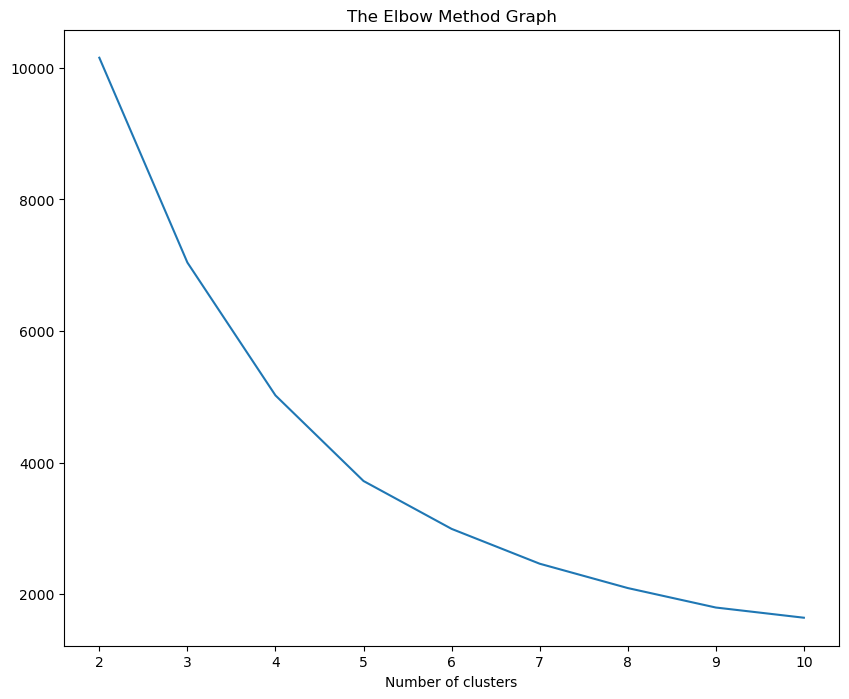

In [62]:
#lets plot the Elbow
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(range(2,11,1),the_scores)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.xticks(ticks=range(2,11))
plt.show()

C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 2 clusters, silhouette score = 0.450943


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 3 clusters, silhouette score = 0.398113


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 4 clusters, silhouette score = 0.439311


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 5 clusters, silhouette score = 0.410644


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 6 clusters, silhouette score = 0.394713


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 7 clusters, silhouette score = 0.386042


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 8 clusters, silhouette score = 0.354739


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 9 clusters, silhouette score = 0.355126


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=15



✅ For 10 clusters, silhouette score = 0.350825


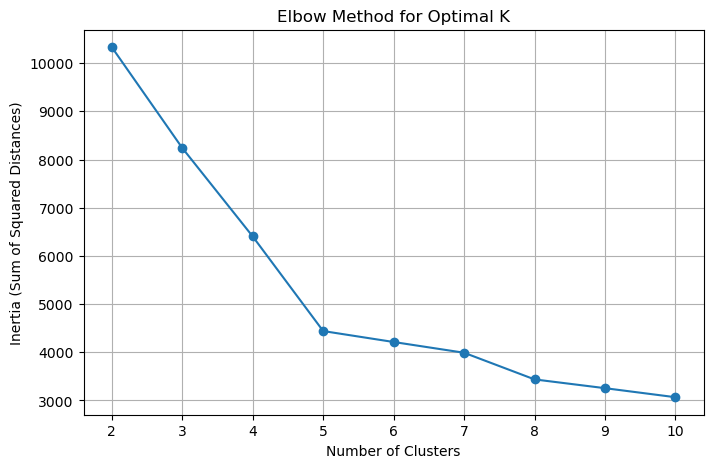

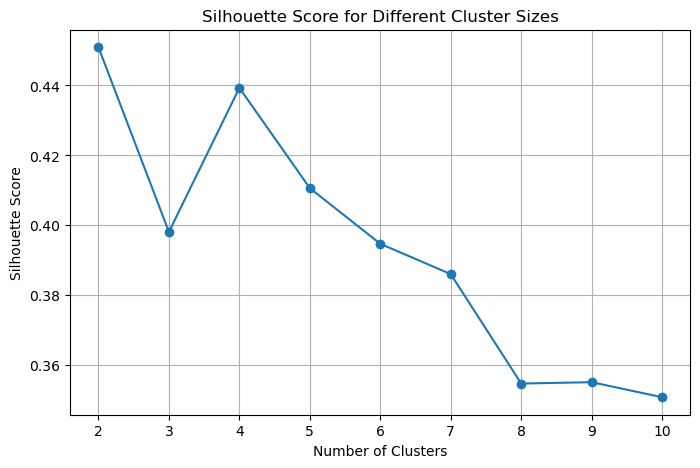

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# ✅ **Fix Windows MKL Memory Leak (Apply Before Running KMeans)**
os.environ["OMP_NUM_THREADS"] = "15"  # Force using 1 thread to prevent leaks

# ✅ **Ensure RFM_df_scaled exists**
if 'RFM_df_scaled' not in locals():
    raise ValueError("❌ Error: 'RFM_df_scaled' is not defined. Ensure it's scaled before running KMeans.")

# 🚀 **Optimized MiniBatchKMeans Function**
def run_mini_batch_kmeans(data, max_clusters=10, batch_size=8192):
    """
    Run MiniBatchKMeans clustering with optimal settings.
    Fixes memory leaks on Windows and improves stability.
    """
    inertias = []
    silhouette_scores = {}

    for k in range(2, max_clusters + 1):
        # ✅ **Set batch_size ≥ 8192 for Windows**
        kmeans = MiniBatchKMeans(
            n_clusters=k,
            batch_size=batch_size,  # 🔥 Ensure large batch size
            max_iter=300,           # 🔥 Increased iterations for stability
            init="k-means++",
            n_init="auto",
            random_state=42
        )
        
        cluster_labels = kmeans.fit_predict(data)

        # Compute inertia and silhouette score
        inertias.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores[k] = silhouette_avg
        print(f"✅ For {k} clusters, silhouette score = {silhouette_avg:.6f}")

    return inertias, silhouette_scores

# 🚀 **Run MiniBatchKMeans with Optimized Settings**
inertias, silhouette_scores = run_mini_batch_kmeans(RFM_df_scaled, batch_size=8192)

# 📈 **Plot the Elbow Curve**
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(inertias) + 2), inertias, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.grid()
plt.show()

# 📈 **Plot Silhouette Scores**
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Cluster Sizes")
plt.grid()
plt.show()


From the above and using best judgment, we are going to use 4 clusters.

In [73]:
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=10,max_iter=50,verbose=0)
kmeans.fit(RFM_df_scaled)

C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.



KMeans(max_iter=50, n_clusters=4, n_init=10)

We will add the clusters to the RFM dataframe

In [74]:
RFM_df['Clusters'] = kmeans.labels_

RFM_df.head()

CustomerID  Recency  Frequency  Monetary  R  F  M  RFM_Score  Clusters
0     12346.0      326          1  77183.60  1  1  4          6         3
1     12747.0        2          9   3489.74  4  4  4         12         1
2     12748.0        1        171  27508.01  4  4  4         12         3
3     12749.0        4          5   4040.88  4  4  4         12         1
4     12820.0        3          4    942.34  4  3  3         10         1

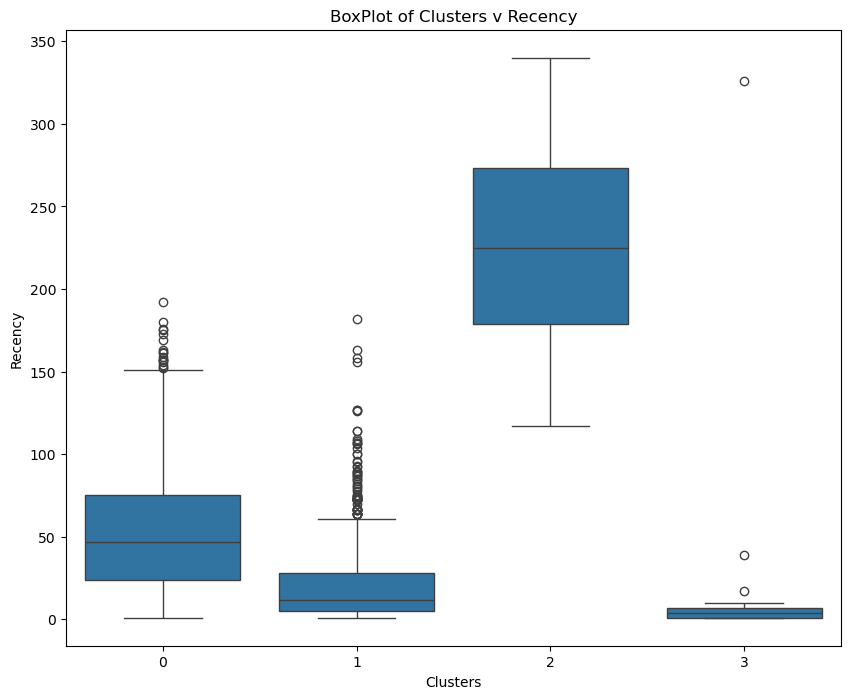

In [75]:
sns.boxplot( x= 'Clusters',y= 'Recency' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Recency")
plt.show()

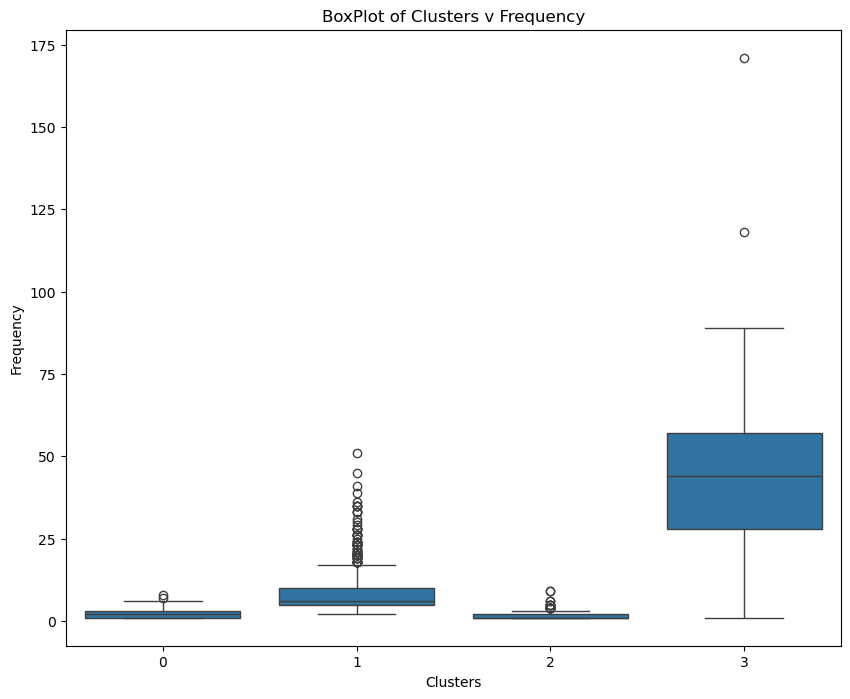

In [76]:
sns.boxplot( x= 'Clusters',y= 'Frequency' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Frequency")
plt.show()

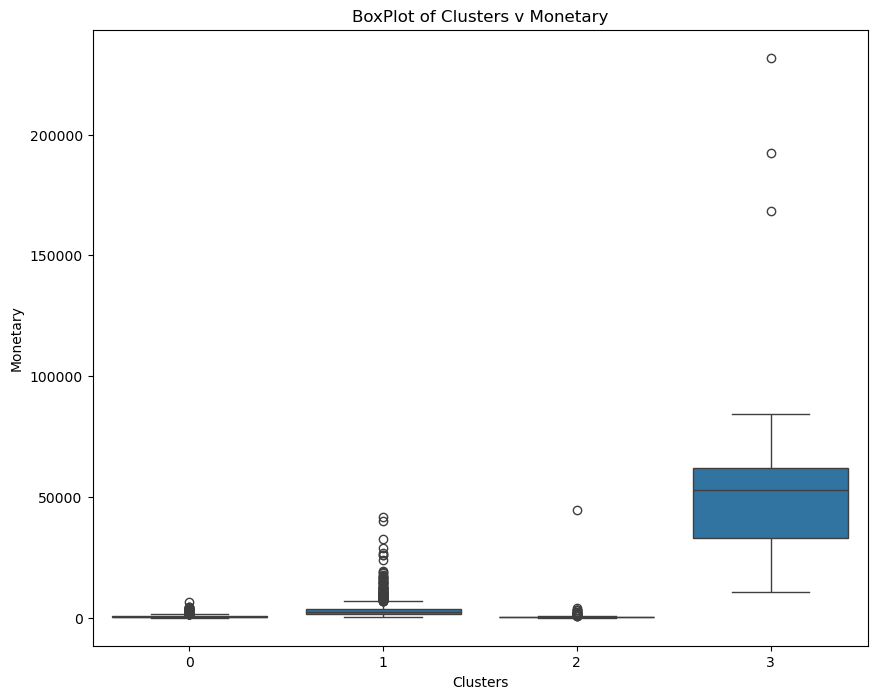

In [77]:
sns.boxplot( x= 'Clusters',y= 'Monetary' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Monetary")
plt.show()

In [78]:
temp_df = RFM_df[["Clusters","RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("Clusters").agg(["mean"])
temp_df.columns = ["RFM_Score mean", "Recency mean", "Frequency mean", "Monetary mean"]
temp_df

RFM_Score mean  Recency mean  Frequency mean  Monetary mean
Clusters                                                             
0               6.910100     53.083241        2.074917     642.791284
1              11.031279     20.445262        8.293468    3322.771978
2               4.279642    227.687919        1.404922     430.260930
3              11.640000     18.280000       51.680000   63680.692000

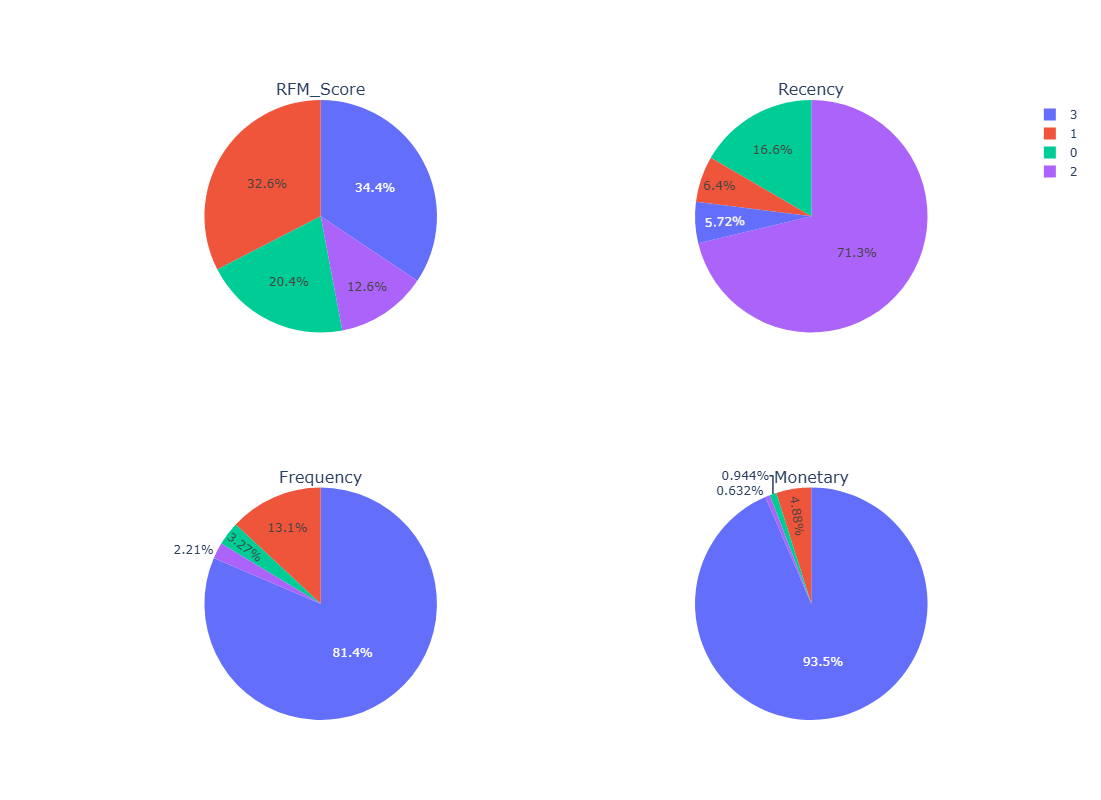

In [79]:
specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("RFM_Score", "Recency", "Frequency","Monetary"),
                    specs=specs
                    )

fig.add_trace(
    go.Pie(values = temp_df['RFM_Score mean'], labels = temp_df.index,
    name = 'RFM_Score'),
    1, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Recency mean'], labels = temp_df.index,
    name = 'Recency'),
    1, 2
)
fig.add_trace(
    go.Pie(values = temp_df['Frequency mean'], labels = temp_df.index,
    name = 'Frequency'),
    2, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Monetary mean'], labels = temp_df.index,
    name = 'Monetary'),
    2, 2
)
fig.update_layout(height=800, width=1200, title_text=" ")
fig.show()

The above pie charts show the percent representation by each cluster concerning the RFM metrics. The customers in the 'blue cluster' have a high average monetary value and high average frequency. The recency of customers in the 'blue cluster is very low among the 4 clusters with 2.1%. The 'red cluster' contains customers with a very low monetary value of 2.79%, recency of 6.81%, and a frequency of 9.15%, this by far is the customers with poor metrics; however, they are better than 'purple' and 'green' customer as far as monetary value is concerned. These red customers, at a glance, are probably customers that the store has had for a long period, but starting to lose interest in the store, these customers can be a prime candidates for targeted promotions. The management has to drill down on the group of customers looking at what they purchase and find the best ways to reel them back. They can even do a filter Market Basket Analysis just for these customers. The 'purple' customers have high recency and low monetary value and frequency, these might be new customers, management targets promotions for this group to entice them to purchase more and frequently. The green customers are somewhat similar to 'red' customers, but with a less monetary value of 0.566%. A filtered MBA can help uncover the buying habits of these customers, which in turn can bring up some ideas on how to improve the monetary and frequency of this group.

### **Product recomendation (people who bought this also bought)**

The product recommendation part of this project is going to make use of the Association Rules that where uncovered in the MBA section. Product recomentation is basically one of the advantages of Market Basket Analysis where you can recommend to customers products that are in the same itemsets as the customer's current products.

In [80]:
from numpy.lib.arraysetops import unique

product_catalog = list(unique(MBA_df['Description']))

In [81]:
rules.head()

antecedents  \
0  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)   
1        (HERB MARKER THYME, HERB MARKER MINT)   
2        (HERB MARKER THYME, HERB MARKER MINT)   
3    (HERB MARKER BASIL, HERB MARKER ROSEMARY)   
4     (HERB MARKER MINT, HERB MARKER ROSEMARY)   

                                   consequents  antecedent support  \
0        (HERB MARKER THYME, HERB MARKER MINT)            0.011793   
1  (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)            0.011260   
2    (HERB MARKER BASIL, HERB MARKER ROSEMARY)            0.011260   
3        (HERB MARKER THYME, HERB MARKER MINT)            0.011616   
4     (HERB MARKER PARSLEY, HERB MARKER THYME)            0.011675   

   consequent support   support  confidence       lift  leverage  conviction  \
0            0.011260  0.010252    0.869347  77.207141  0.010120    7.567664   
1            0.011793  0.010252    0.910526  77.207141  0.010120   11.044663   
2            0.011616  0.010015    0.889474  76.576423  0.009885    8.942526   
3            0.011260  0.010015    0.862245  76.576423  0.009885    7.177521   
4            0.011497  0.010252    0.878173  76.382909  0.010118    8.113962   

   zhangs_metric  
0       0.998827  
1       0.998288  
2       0.998181  
3       0.998540  
4       0.998566

In [82]:
def remove_from_list(y, item_to_search):
  newlist = list()
  for i in y:
    if i not in item_to_search:
      newlist.append(i)
  return newlist

In [83]:
def search_list(item_to_search, list_to_search = rules['antecedents']):
  print(item_to_search)
  max_lift = 0
  item_to_recommend = ''
  for i, item in enumerate(list_to_search):
    if set(list(item_to_search)).issubset(set(list(item))):
      if rules['lift'][i] > max_lift:
        max_lift = rules['lift'][i]
        y = list(rules['antecedents'][i])
        x = remove_from_list(y, item_to_search)
        item_to_recommend = list(rules['consequents'][i]) + x
  if item_to_recommend == '':
    print("There are no Product recommendations")
  else:
    return print(f"People who bought this also bought: {item_to_recommend}")


In [84]:
for i in range(len(product_catalog)):
  search_list([product_catalog[i]])

['10 COLOUR SPACEBOY PEN']
There are no Product recommendations
['12 COLOURED PARTY BALLOONS']
There are no Product recommendations
['12 DAISY PEGS IN WOOD BOX']
There are no Product recommendations
['12 EGG HOUSE PAINTED WOOD']
There are no Product recommendations
['12 HANGING EGGS HAND PAINTED']
There are no Product recommendations
['12 IVORY ROSE PEG PLACE SETTINGS']
There are no Product recommendations
['12 MESSAGE CARDS WITH ENVELOPES']
There are no Product recommendations
['12 PENCIL SMALL TUBE WOODLAND']
There are no Product recommendations
['12 PENCILS SMALL TUBE RED RETROSPOT']
There are no Product recommendations
['12 PENCILS SMALL TUBE SKULL']
There are no Product recommendations
['12 PENCILS TALL TUBE POSY']
There are no Product recommendations
['12 PENCILS TALL TUBE RED RETROSPOT']
There are no Product recommendations
['12 PENCILS TALL TUBE SKULLS']
There are no Product recommendations
['12 PENCILS TALL TUBE WOODLAND']
There are no Product recommendations
['12 PINK HEN+CHI

In [91]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth

# Step 1: Remove infrequent items (keep items that appear in at least 10 transactions)
min_item_frequency = 10
item_counts = basket.sum(axis=0)
frequent_items = item_counts[item_counts >= min_item_frequency].index
basket_filtered = basket[frequent_items]

# Step 2: Convert to boolean type for memory efficiency
basket_filtered = basket_filtered.astype(bool)

# Step 3: Set min_support dynamically and use FP-Growth (faster and memory efficient)
min_support_value = max(0.01, 20 / len(basket_filtered))  # Ensures at least 20 transactions contribute
frequent_itemsets = fpgrowth(basket_filtered, min_support=min_support_value, use_colnames=True)

# Step 4: Display results
print("Top Frequent Itemsets:")
display(frequent_itemsets.head(10))  # Show top 10 frequent itemsets


Top Frequent Itemsets:


support                              itemsets
0  0.108385  (CREAM HANGING HEART T-LIGHT HOLDER)
1  0.108111             (JUMBO BAG RED RETROSPOT)
2  0.063769             (JUMBO BAG PINK POLKADOT)
3  0.056141              (JAM MAKING SET PRINTED)
4  0.037866             (RECYCLING BAG RETROSPOT)
5  0.029964           (RED RETROSPOT SHOPPER BAG)
6  0.022555                (RECIPE BOX RETROSPOT)
7  0.018494       (CHILDRENS APRON APPLES DESIGN)
8  0.017726                  (RED RETROSPOT WRAP)
9  0.014872                (PEG BAG APPLE DESIGN)

Top Association Rules:


antecedents                           consequents  \
0             (JUMBO BAG RED RETROSPOT)  (CREAM HANGING HEART T-LIGHT HOLDER)   
1  (CREAM HANGING HEART T-LIGHT HOLDER)             (JUMBO BAG RED RETROSPOT)   
2             (JUMBO BAG RED RETROSPOT)             (JUMBO BAG PINK POLKADOT)   
3             (JUMBO BAG PINK POLKADOT)             (JUMBO BAG RED RETROSPOT)   
4             (JUMBO BAG PINK POLKADOT)  (CREAM HANGING HEART T-LIGHT HOLDER)   
5  (CREAM HANGING HEART T-LIGHT HOLDER)             (JUMBO BAG PINK POLKADOT)   
6             (JUMBO BAG PINK POLKADOT)                (LUNCH BAG RED SPOTTY)   
7                (LUNCH BAG RED SPOTTY)             (JUMBO BAG PINK POLKADOT)   
8             (JUMBO BAG PINK POLKADOT)             (LUNCH BAG  BLACK SKULL.)   
9             (LUNCH BAG  BLACK SKULL.)             (JUMBO BAG PINK POLKADOT)   

    support  confidence      lift  
0  0.019811    0.183249  1.690713  
1  0.019811    0.182785  1.690713  
2  0.043080    0.398477  6.248753  
3  0.043080    0.675559  6.248753  
4  0.010262    0.160929  1.484788  
5  0.010262    0.094684  1.484788  
6  0.016518    0.259036  3.193611  
7  0.016518    0.203654  3.193611  
8  0.013500    0.211704  3.190794  
9  0.013500    0.203474  3.190794

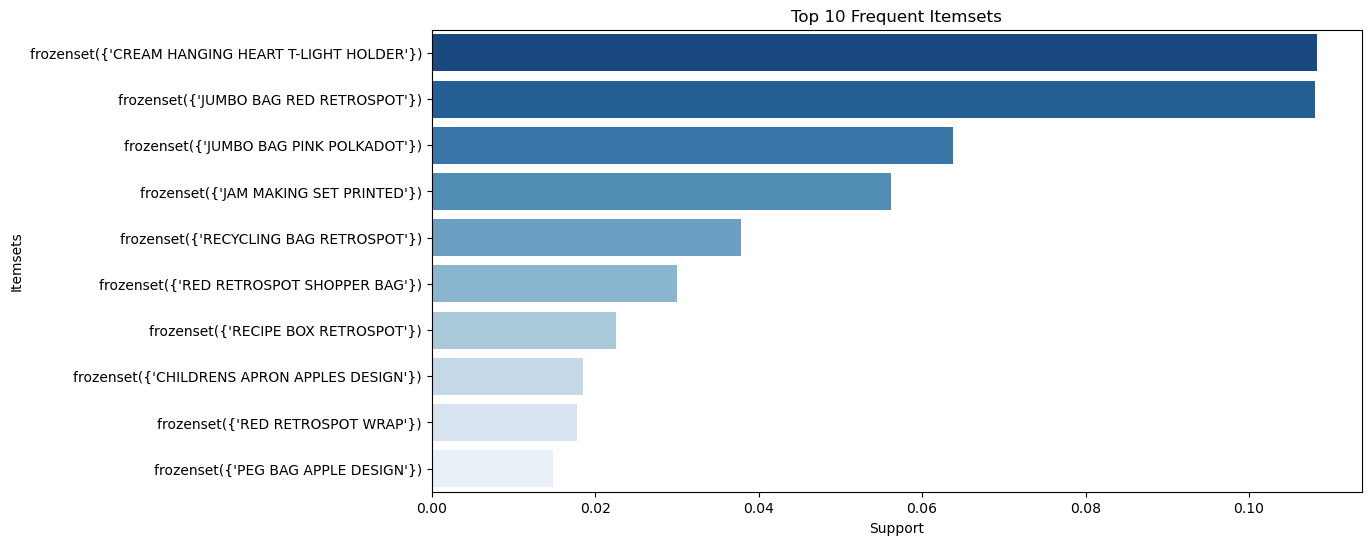

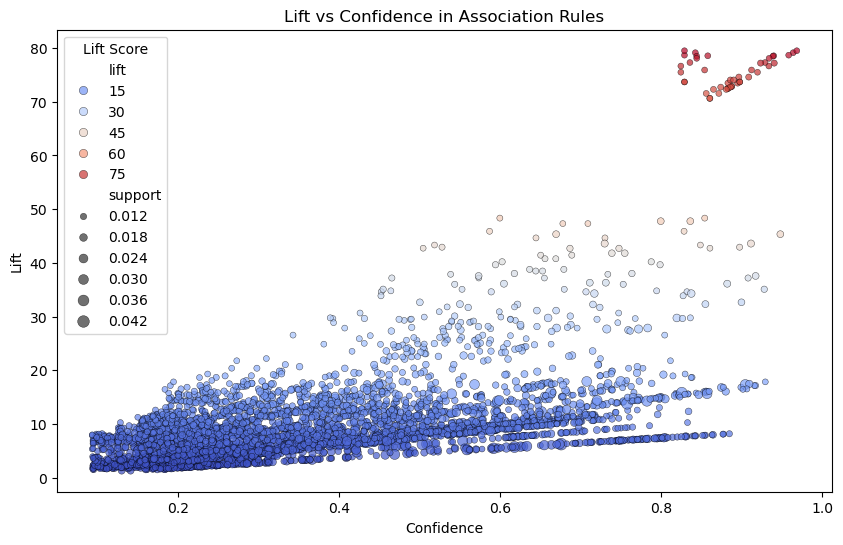

 Customers who bought JUMBO BAG RED RETROSPOT also bought: ['JUMBO STORAGE BAG SUKI', 'JUMBO BAG SCANDINAVIAN BLUE PAISLEY']


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import association_rules

# Step 1: Generate Association Rules
min_threshold_value = max(0.5, frequent_itemsets['support'].median())  # Dynamic threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold_value)

# Step 2: Display Top Rules
print("Top Association Rules:")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Step 3: Bar Plot of Top 10 Frequent Items
plt.figure(figsize=(12, 6))
sns.barplot(x=frequent_itemsets['support'].head(10), y=frequent_itemsets['itemsets'].head(10).astype(str), palette="Blues_r")
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.show()

# Step 4: Scatter Plot of Lift vs Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules['confidence'], y=rules['lift'], size=rules['support'], hue=rules['lift'], palette="coolwarm", edgecolor="black", alpha=0.7)
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Lift vs Confidence in Association Rules')
plt.legend(title="Lift Score")
plt.show()

# Step 5: Function for Product Recommendations
def recommend_product(item):
    matching_rules = rules[rules['antecedents'].apply(lambda x: item in x)]
    if matching_rules.empty:
        print(" No product recommendations found.")
    else:
        top_recommendation = matching_rules.sort_values(by="lift", ascending=False).iloc[0]
        print(f" Customers who bought {item} also bought: {list(top_recommendation['consequents'])}")

# Example Usage: Recommend for a top-selling product
recommend_product("JUMBO BAG RED RETROSPOT")


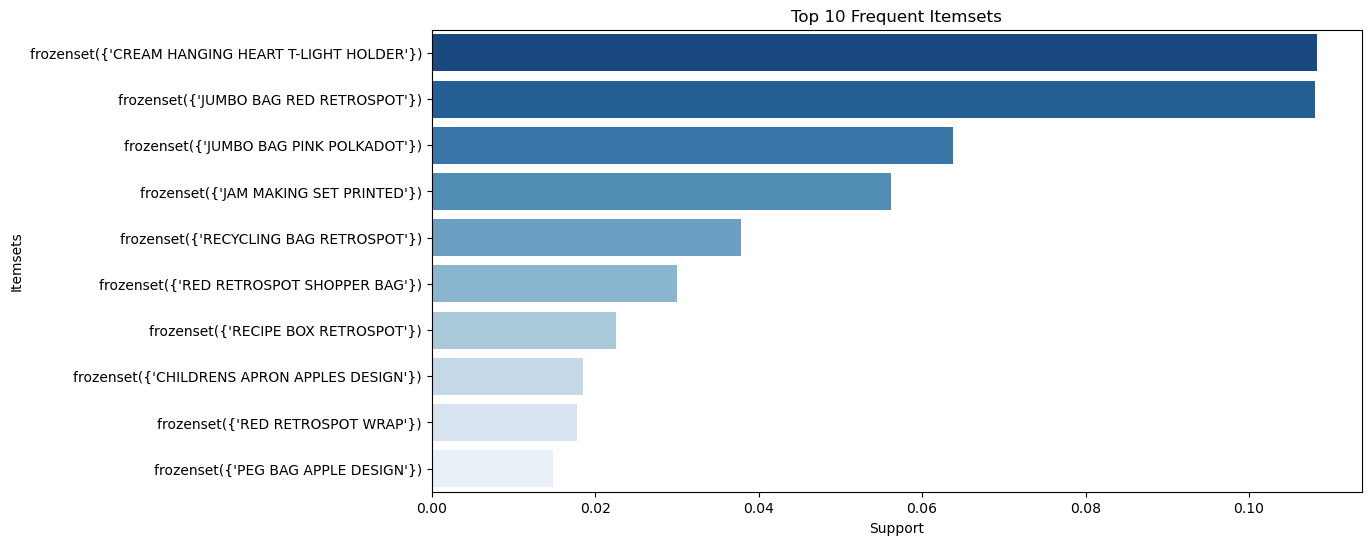

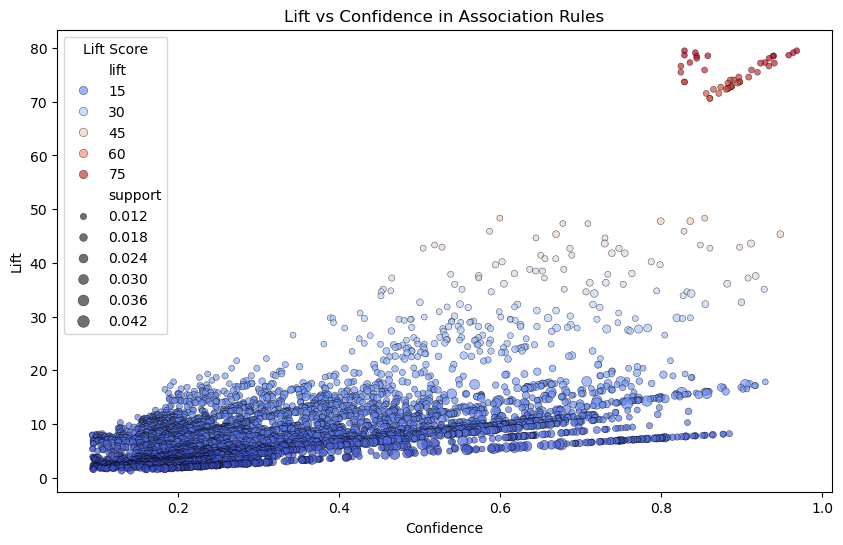

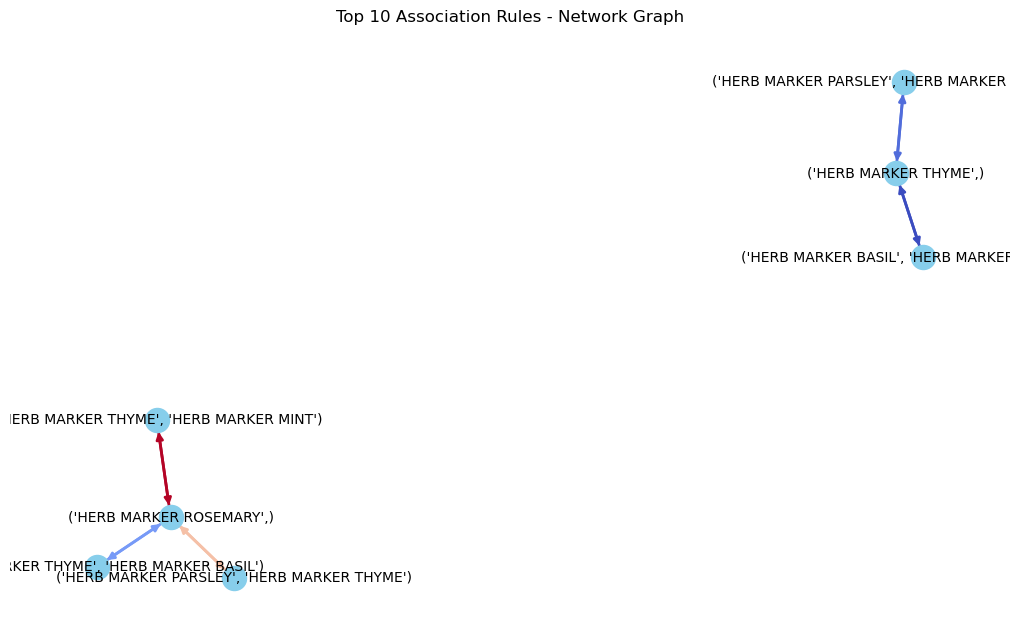

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from mlxtend.frequent_patterns import association_rules

# Step 1: Generate Association Rules (Filter and Optimize)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by="lift", ascending=False).reset_index(drop=True)

# Step 2: 📊 **Bar Chart of Top 10 Frequent Itemsets**
plt.figure(figsize=(12, 6))
sns.barplot(x=frequent_itemsets['support'].head(10), y=frequent_itemsets['itemsets'].head(10).astype(str), palette="Blues_r")
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.show()

# Step 3: 📈 **Scatter Plot for Lift vs Confidence**
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules['confidence'], y=rules['lift'], size=rules['support'], hue=rules['lift'], palette="coolwarm", edgecolor="black", alpha=0.7)
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Lift vs Confidence in Association Rules')
plt.legend(title="Lift Score")
plt.show()

# Step 4: 🔗 **Network Graph for Top 10 Rules**
plt.figure(figsize=(10, 6))
G = nx.DiGraph()
top_rules = rules.head(10)

for i, rule in top_rules.iterrows():
    antecedent = tuple(rule['antecedents'])
    consequent = tuple(rule['consequents'])
    G.add_edge(antecedent, consequent, weight=rule['lift'])

pos = nx.spring_layout(G)
edges = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=weights, edge_cmap=plt.cm.coolwarm, width=2, font_size=10)
plt.title('Top 10 Association Rules - Network Graph')
plt.show()

# Step 5: 🔥 **Heatmap of Lift Scores**
lift_pivot = rules.pivot(index="antecedents", columns="consequents", values="lift").fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(lift_pivot, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Lift Score Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Step 6: 🎯 **Parallel Coordinates Plot (Comparing Multiple Rule Properties)**
from pandas.plotting import parallel_coordinates

rules_subset = rules[['support', 'confidence', 'lift']].head(20)  # Select Top 20 Rules
rules_subset['Index'] = rules_subset.index.astype(str)  # Convert index for visualization

plt.figure(figsize=(12, 6))
parallel_coordinates(rules_subset, class_column="Index", colormap=plt.cm.coolwarm, alpha=0.7)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Parallel Coordinates Plot of Top Association Rules")
plt.show()
